# ***Anime Recommendation System***

This notebook shows the process and orientation in building an anime recommendation system.


This notebook was created by: ***Leor Ariel Rose***, ***Or Haim Tabibi***, ***Yahav Bar David***.


## ***Import Libraries***

Lets install all necessary libraries for this notebook.

In [1]:
!pip install requests
!pip install surprise
!pip install pandas
!pip install seaborn
!pip install matplotlib

Lets import all necessary libraries for this notebook.

In [2]:
import os
import requests
import zipfile
import io
import surprise
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from typing import List, Dict, Tuple
from collections import defaultdict
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor
from surprise import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import BaselineOnly, CoClustering
from surprise.model_selection import GridSearchCV, KFold
from surprise.prediction_algorithms.predictions import Prediction

## ***Constants and Configurations***

In [3]:
# graphs settings
%matplotlib inline
sns.set_style("darkgrid")
plt.style.use('classic')
sns.set()

## ***Preprocess and Data Exploration***

We will use the [anime data set](https://www.kaggle.com/CooperUnion/anime-recommendations-database). we will download it from a copy we created in our github repository [***name***](https://github.com/leorrose/anime).

In our data set we have two csv (rating.csv, anime.csv) files lets take a look at them.

#### ***Rating csv***

Lets read our data:

In [4]:
rating_df: pd.DataFrame = pd.read_csv('https://github.com/leorrose/AnimeRS/raw/main/app/data/rating.csv')
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [5]:
print(f"Shape: {rating_df.shape}")

Shape: (7813737, 3)


What each column represents:
- user_id - unique user id.
- anime_id - the anime that this user has rated.
- rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).


#### ***Anime csv***

Lets read our data:

In [6]:
anime_df: pd.DataFrame = pd.read_csv('https://github.com/leorrose/AnimeRS/raw/main/app/data/anime.csv')
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [7]:
print(f"Shape: {anime_df.shape}")

Shape: (12294, 7)


What each column represents:
- anime_id - unique id identifying an anime.
- name - full name of anime.
- genre - comma separated list of genres for this anime.
- type - movie, TV, OVA, etc.
- episodes - how many episodes in this show. (1 if movie).
- rating - average rating out of 10 for this anime.
- members - number of community members that are in this anime's "group".

#### ***Create one dataset***

Lets combine both datasets to get a complete one dataset:

In [8]:
data_df: pd.DataFrame  =  pd.merge(rating_df, anime_df, on="anime_id")
data_df.head()

,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members
0,1,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
1,3,20,8,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
2,5,20,6,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
3,6,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
4,10,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297


In [9]:
print(f"Shape: {data_df.shape}")

Shape: (7813727, 9)


#### ***Pre Process***

Lets take a look at our data:

In [10]:
data_df.describe()

,user_id,anime_id,rating_x,rating_y,members
count,7.813727e+06,7.813727e+06,7.813727e+06,7.813721e+06,7.813727e+06
mean,3.672795e+04,8.909045e+03,6.144036e+00,7.653127e+00,1.786208e+05
std,2.099795e+04,8.883923e+03,3.727796e+00,6.730287e-01,1.881764e+05
min,1.000000e+00,1.000000e+00,-1.000000e+00,1.670000e+00,2.900000e+01
25%,1.897400e+04,1.240000e+03,6.000000e+00,7.270000e+00,4.403000e+04
50%,3.679100e+04,6.213000e+03,7.000000e+00,7.680000e+00,1.104700e+05
75%,5.475700e+04,1.409300e+04,9.000000e+00,8.130000e+00,2.442680e+05
max,7.351600e+04,3.451900e+04,1.000000e+01,9.500000e+00,1.013917e+06


Lets see if we have rows with missing values:

In [11]:
data_df.isna().sum()

user_id       0
anime_id      0
rating_x      0
name          0
genre       110
type          4
episodes      0
rating_y      6
members       0
dtype: int64

Lets remove rows with missing values and rows with user rating of -1 meaning the user watched the anime but didn't give a rating, we will drop theese rows:

In [12]:
data_df: pd.DataFrame = data_df.dropna()
data_df: pd.DataFrame = data_df[data_df.rating_x != -1]
print(f"Shape: {data_df.shape}")

Shape: (6337146, 9)


We still have a lot of data for it to work efficiently in free google colab. lets reduce our data size. We will remove all users that gave more than 250 reviews and anime's that have less than 250 reviews:

In [13]:
min_anime_ratings:int = 250
filter_anime: pd.Series = data_df['anime_id'].value_counts() > min_anime_ratings
filter_anime: pd.DataFrame = filter_anime[filter_anime].index.tolist()

min_user_ratings:int = 250
filter_users: pd.Series = data_df['user_id'].value_counts() > min_user_ratings
filter_users: pd.DataFrame = filter_users[filter_users].index.tolist()

data_df: pd.DataFrame  = data_df[(
    data_df['anime_id'].isin(filter_anime)) & 
    (data_df['user_id'].isin(filter_users))]
print(data_df.shape)

(2368822, 9)


Still its to much data we will reduce it to 100000 sample:

In [14]:
data_df: pd.DataFrame  = data_df.sample(n=100000, random_state=42)
data_df.shape

(100000, 9)

Lets turn our genre lists into one hot columns for easy use:

In [15]:
# get uniqe genres
uniqe_genres: np.ndarray = np.unique(
    [*itertools.chain.from_iterable(data_df.genre.apply(
        lambda x: x.split(',')))])

# create genres columns 
genres_columns: np.ndarray = np.asarray(
    list(map(lambda x: x.strip(), uniqe_genres)))

for genres_column in genres_columns:
  tmp: pd.Series = data_df.genre.str.contains(genres_column)
  tmp[tmp == True] = 1
  tmp[tmp == False] = 0
  data_df['Genre.' + genres_column] = tmp

data_df: pd.DataFrame = data_df.drop('genre', axis=1)
data_df.head()

,user_id,anime_id,rating_x,name,type,episodes,rating_y,members,Genre.Adventure,Genre.Cars,Genre.Comedy,Genre.Dementia,Genre.Demons,Genre.Drama,Genre.Ecchi,Genre.Fantasy,Genre.Game,Genre.Harem,Genre.Hentai,Genre.Historical,Genre.Horror,Genre.Josei,Genre.Kids,Genre.Magic,Genre.Martial Arts,Genre.Mecha,Genre.Military,Genre.Music,Genre.Mystery,Genre.Parody,Genre.Police,Genre.Psychological,Genre.Romance,Genre.Samurai,Genre.School,Genre.Sci-Fi,Genre.Seinen,Genre.Shoujo,Genre.Shoujo Ai,Genre.Shounen,Genre.Shounen Ai,Genre.Slice of Life,Genre.Space,Genre.Sports,Genre.Super Power,Genre.Supernatural,Genre.Thriller,Genre.Vampire,Genre.Yaoi,Genre.Yuri,Genre.Action
914939,40648,20787,8,Black Bullet,TV,13,7.44,320267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2202859,5815,1840,7,Zero no Tsukaima: Futatsuki no Kishi,TV,12,7.73,235684,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6491060,60879,2514,8,Detective Conan OVA 04: Conan and Kid and Crys...,OVA,1,7.64,8974,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6261940,16228,7655,8,Major S6,TV,25,8.49,24788,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1663607,61110,72,10,Full Metal Panic? Fumoffu,TV,12,8.21,171086,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Lets turn our type column into one hot columns for easy use:

In [16]:
uniqe_types: np.ndarray = data_df.type.unique()

for uniqe_type in uniqe_types:
  tmp: pd.Series = data_df.type == uniqe_type
  tmp[tmp == True] = 1
  tmp[tmp == False] = 0
  data_df['Type.' + uniqe_type] = tmp

data_df: pd.DataFrame = data_df.drop('type', axis=1)
data_df.head()

,user_id,anime_id,rating_x,name,episodes,rating_y,members,Genre.Adventure,Genre.Cars,Genre.Comedy,Genre.Dementia,Genre.Demons,Genre.Drama,Genre.Ecchi,Genre.Fantasy,Genre.Game,Genre.Harem,Genre.Hentai,Genre.Historical,Genre.Horror,Genre.Josei,Genre.Kids,Genre.Magic,Genre.Martial Arts,Genre.Mecha,Genre.Military,Genre.Music,Genre.Mystery,Genre.Parody,Genre.Police,Genre.Psychological,Genre.Romance,Genre.Samurai,Genre.School,Genre.Sci-Fi,Genre.Seinen,Genre.Shoujo,Genre.Shoujo Ai,Genre.Shounen,Genre.Shounen Ai,Genre.Slice of Life,Genre.Space,Genre.Sports,Genre.Super Power,Genre.Supernatural,Genre.Thriller,Genre.Vampire,Genre.Yaoi,Genre.Yuri,Genre.Action,Type.TV,Type.OVA,Type.Movie,Type.Special,Type.ONA,Type.Music
914939,40648,20787,8,Black Bullet,13,7.44,320267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2202859,5815,1840,7,Zero no Tsukaima: Futatsuki no Kishi,12,7.73,235684,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
6491060,60879,2514,8,Detective Conan OVA 04: Conan and Kid and Crys...,1,7.64,8974,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6261940,16228,7655,8,Major S6,25,8.49,24788,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1663607,61110,72,10,Full Metal Panic? Fumoffu,12,8.21,171086,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


#### ***Data Exploration***

##### ***Distribution of User Rating***
Lets visualize our user rating distribution:

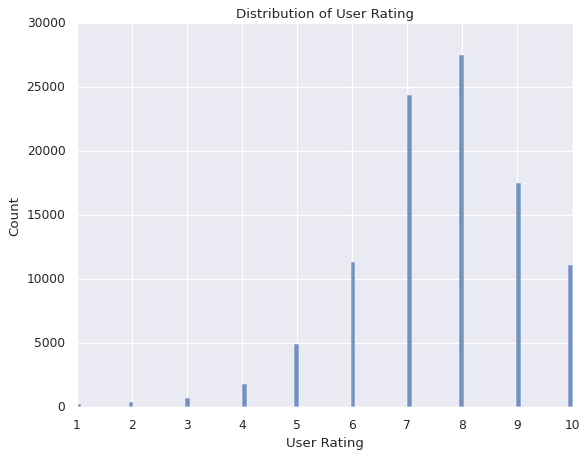

In [17]:
sns.histplot(data_df, x="rating_x")
plt.xlabel("User Rating")
plt.ylabel("Count")
plt.title("Distribution of User Rating")
plt.show()

As we can see most of the ratings are above 5 meaning the users give more positive ratings than negative ratings. we will need to take this into consideration when we evaluate our recomendations because by this graph ratings with value 7 and more are considered good recommandations.

##### ***Distribution of Number of Ratings Per User***
Lets visualize the number of ratings per user distribution:

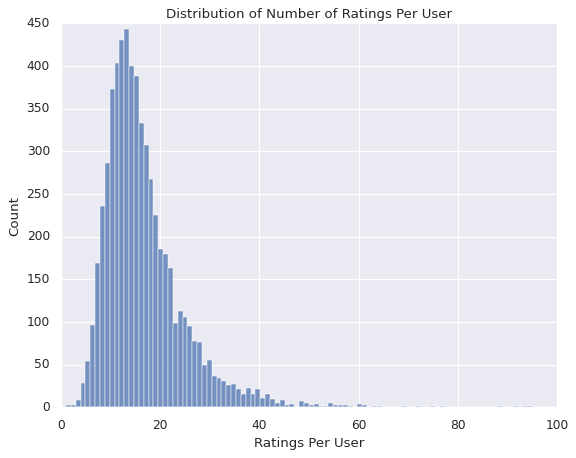

In [18]:
sns.histplot(
    data_df.groupby('user_id', as_index=False)['rating_x'].count(), 
    x="rating_x")
plt.xlabel("Ratings Per User")
plt.ylabel("Count")
plt.title("Distribution of Number of Ratings Per User")
plt.show()

As we can see we have a nice distribution of ratings per user meaning we have user who have a lot of rating and users who gave almost no ratings but most of the users gave between 9-19 ratings.

##### ***Distribution of Number of Ratings Per Anime Id***
Lets visualize the distribution of number of ratings per anime_id

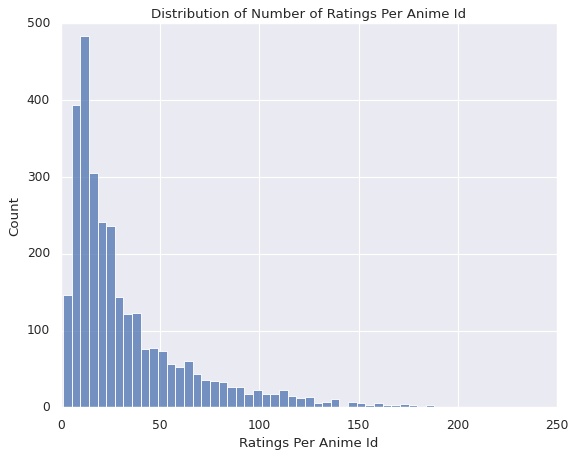

In [19]:
sns.histplot(
    data_df.groupby('anime_id', as_index=False)['rating_x'].count(), 
    x="rating_x")
plt.xlabel("Ratings Per Anime Id")
plt.ylabel("Count")
plt.title("Distribution of Number of Ratings Per Anime Id")
plt.show()

As we can see the number of ratings each anime got is distrubted nicely. some got a lot and some got single ratings but most of the animes got between 5-20 ratings. This means that we can use thees anime's to get good results because they have a differnet amounts of ratings and not one value. Also most of the anime's don't have a lot of ratings so it wont be biased to them.

##### ***Number of Ratings Per Genre***
Lets visualize the number of ratings per genre

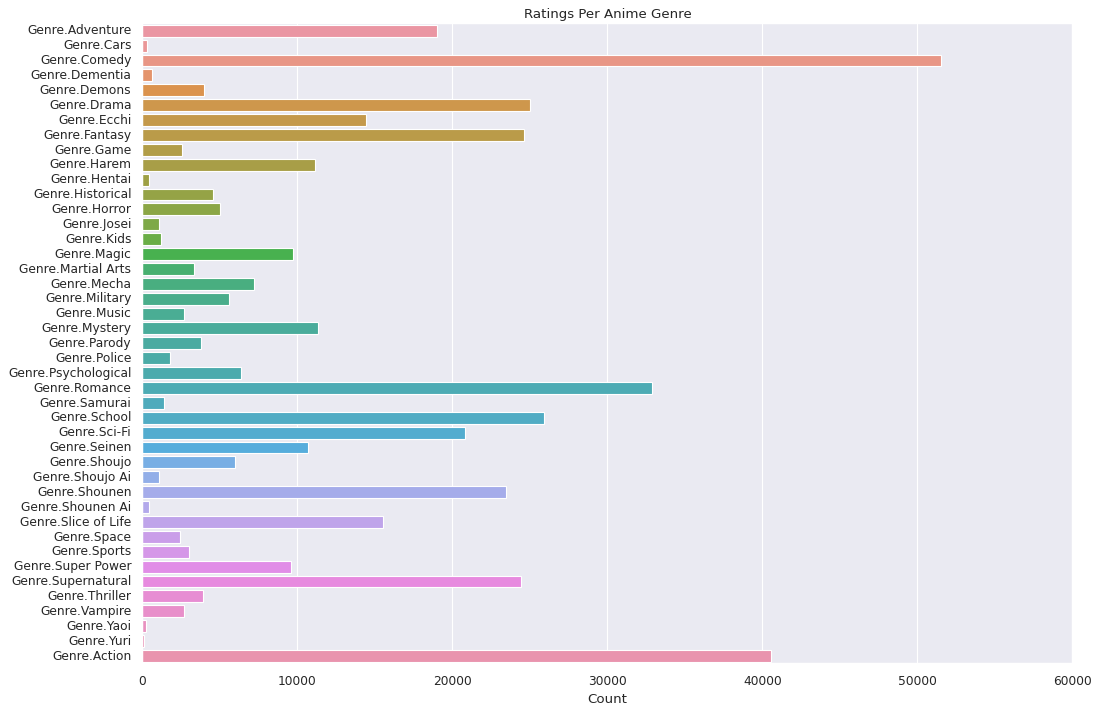

In [20]:
ratings_per_genre: pd.DataFrame = pd.DataFrame(
    data_df.loc[:, 'Genre.Adventure':'Genre.Action'].sum(), 
    columns=['sum'])
plt.figure(figsize=(15,10))
sns.barplot(data=ratings_per_genre, y=ratings_per_genre.index, 
            x='sum', estimator=sum)
plt.xlabel("Count")
plt.title("Ratings Per Anime Genre")
plt.show()

##### ***Number of Ratings Per Type***
Lets visualize the number of ratings per type

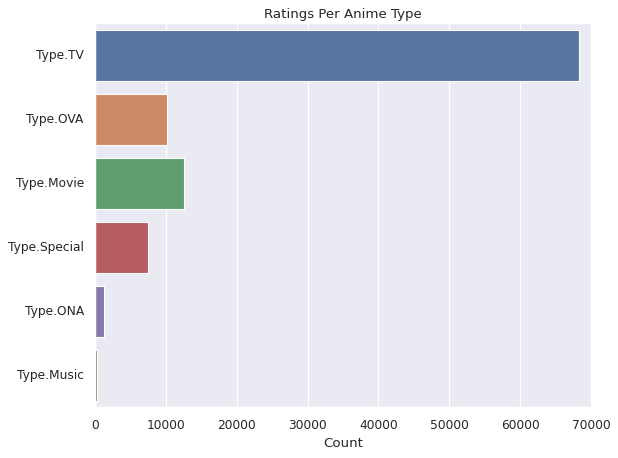

In [21]:
ratings_per_genre: pd.DataFrame = pd.DataFrame(
    data_df.loc[:, 'Type.TV':'Type.Music'].sum(), 
    columns=['sum'])
sns.barplot(data=ratings_per_genre, y=ratings_per_genre.index, 
            x='sum', estimator=sum)
plt.xlabel("Count")
plt.title("Ratings Per Anime Type")
plt.show()

##### ***Rating vs Members***

Lets visualize the correlation between members and ratings

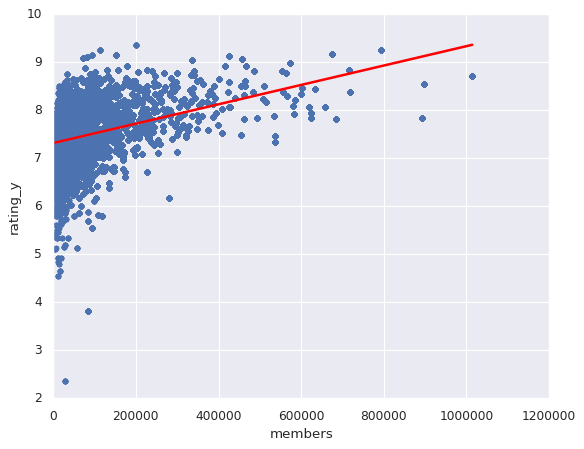

In [22]:
sns.regplot(x=data_df["members"], y=data_df["rating_y"], 
            line_kws={'color':'red'})
plt.show()

As we can see we have a positive correlation mening more members the higher the ratings.

## ***Building, Training and Testing***

### ***Suprise Util Methods***
First lets define some method to help us evaluate our suprise models.

#### ***Get Top n Recommendations***

In [23]:
def get_top_n(predictions: List[Prediction], n: int=10
                              ) -> Dict[int, List[Tuple[int, float]]]:
    """
    Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(List[Prediction]): The list of predictions, as 
        returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. 
        Default is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
      # add to users list the item id and its estimated rating
      top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
      # sort users item prediction by estimated rating
      user_ratings.sort(key=lambda x: x[1], reverse=True)
      # slice only top n
      top_n[uid] = user_ratings[:n]
    
    return top_n

#### ***Precision and Recall***

In [24]:
def precision_recall_at_k(predictions:List[Prediction], k:int=10,
                          threshold:float=3.5) -> Tuple[Dict[int, float]]:
    """
    Return precision and recall at k metrics for each user
    
    Args:
        predictions(List[Prediction]): The list of predictions, as 
        returned by the test method of an algorithm.
        k(int): The number of recommendation to look at for each user. 
        Default is 10.
        threshold(float): the rating treshould to call relevant

    Returns:
    A tuple of two dicts where keys are user (raw) ids and values 
    precision\recall
    """

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

### ***Collaborative Filtering - User Based***

#### ***SVD***

Createing data objects for surprise:

In [25]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the SVD model (we will use the default values for creation):

In [26]:
algo: SVD = SVD()

Lets see the SVD performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [27]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
svd_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

svd_results['RMSE'] = svd_results.loc[:, 'split_1_rmse': 'split_5_rmse'].mean(
    axis=1)
svd_results['MSE'] = svd_results.loc[:, 'split_1_mse': 'split_5_mse'].mean(
    axis=1)
svd_results['MAE'] = svd_results.loc[:, 'split_1_mae': 'split_5_mae'].mean(
    axis=1)
svd_results['P@5'] = svd_results.loc[:, 'split_1_P@5': 'split_5_P@5'].mean(
    axis=1)
svd_results['R@5'] = svd_results.loc[:, 'split_1_R@5': 'split_5_R@5'].mean(
    axis=1)
svd_results['F1@5'] = svd_results.loc[:, 'split_1_F1@5': 'split_5_F1@5'].mean(
    axis=1)
svd_results['P@10'] = svd_results.loc[:, 'split_1_P@10': 'split_5_P@10'].mean(
    axis=1)
svd_results['R@10'] = svd_results.loc[:, 'split_1_R@10': 'split_5_R@10'].mean(
    axis=1)
svd_results['F1@10'] = svd_results.loc[:, 
                                       'split_1_F1@10': 'split_5_F1@10'].mean(
                                           axis=1)
svd_results['P@15'] = svd_results.loc[:,
                                      'split_1_P@15': 'split_5_P@15'].mean(
                                          axis=1)
svd_results['R@15'] = svd_results.loc[:,
                                      'split_1_R@15': 'split_5_R@15'].mean(
                                          axis=1)
svd_results['F1@15'] = svd_results.loc[:,
                                       'split_1_F1@15': 'split_5_F1@15'].mean(
                                           axis=1)
svd_results = svd_results.set_index(pd.Index(['SVD']))

In [28]:
svd_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
SVD,1.24002,1.249941,1.249904,1.254973,1.23948,1.537648,1.562352,1.562259,1.574957,1.536311,0.941863,0.95087,0.956837,0.954993,0.950571,0.832336,0.819091,0.825364,0.82412,0.821756,0.817035,0.821619,0.824723,0.819448,0.82225,0.821788,0.822701,0.822058,0.820917,0.819102,0.816932,0.806936,0.808712,0.808625,0.808423,0.826934,0.832004,0.83643,0.83544,0.829137,0.835645,0.838271,0.836384,0.831502,0.829535,0.824562,0.812968,0.816953,0.816299,0.815035,0.821955,0.826779,0.830535,0.827367,0.825679,0.828658,0.830413,0.829159,0.826175,0.824285,1.246863,1.554706,0.951027,0.824533,0.809926,0.817163,0.821015,0.831989,0.826463,0.821313,0.834267,0.827738


#### ***SVDpp***

Createing data objects for surprise:

In [29]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the SVDpp model (we will use the default values for creation):

In [30]:
algo: SVDpp = SVDpp()

Lets see the SVDpp performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [31]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
svdpp_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

svdpp_results['RMSE'] = svdpp_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
svdpp_results['MSE'] = svdpp_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
svdpp_results['MAE'] = svdpp_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
svdpp_results['P@5'] = svdpp_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
svdpp_results['R@5'] = svdpp_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
svdpp_results['F1@5'] = svdpp_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
svdpp_results['P@10'] = svdpp_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
svdpp_results['R@10'] = svdpp_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
svdpp_results['F1@10'] = svdpp_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
svdpp_results['P@15'] = svdpp_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
svdpp_results['R@15'] = svdpp_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
svdpp_results['F1@15'] = svdpp_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
svdpp_results = svdpp_results.set_index(pd.Index(['SVDpp']))

In [32]:
svdpp_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
SVDpp,1.246432,1.227876,1.242171,1.252255,1.235583,1.553592,1.507679,1.542988,1.568142,1.526665,0.946416,0.938574,0.941173,0.950608,0.941945,0.821557,0.814208,0.81347,0.812867,0.81374,0.817078,0.813408,0.806949,0.812527,0.814362,0.807411,0.81664,0.810925,0.816723,0.820448,0.789236,0.788223,0.785518,0.78311,0.78597,0.811086,0.806543,0.801966,0.807205,0.806203,0.805241,0.809735,0.806133,0.811066,0.811571,0.805073,0.801005,0.79925,0.797711,0.799614,0.814071,0.809961,0.804449,0.809857,0.810262,0.806324,0.813173,0.808522,0.813885,0.815985,1.240863,1.539813,0.943743,0.815169,0.786412,0.800531,0.812865,0.8066,0.80972,0.814429,0.808749,0.811578


#### ***SlopeOne***

Createing data objects for surprise:

In [33]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the SlopeOne model (we will use the default values for creation):

In [34]:
algo: SlopeOne = SlopeOne()

Lets see the SlopeOne performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [35]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
slope_one_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

slope_one_results['RMSE'] = slope_one_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
slope_one_results['MSE'] = slope_one_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
slope_one_results['MAE'] = slope_one_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
slope_one_results['P@5'] = slope_one_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
slope_one_results['R@5'] = slope_one_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
slope_one_results['F1@5'] = slope_one_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
slope_one_results['P@10'] = slope_one_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
slope_one_results['R@10'] = slope_one_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
slope_one_results['F1@10'] = slope_one_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
slope_one_results['P@15'] = slope_one_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
slope_one_results['R@15'] = slope_one_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
slope_one_results['F1@15'] = slope_one_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
slope_one_results = slope_one_results.set_index(pd.Index(['SlopeOne']))

In [36]:
slope_one_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
SlopeOne,1.476581,1.486202,1.501073,1.48433,1.487282,2.180293,2.208795,2.25322,2.203236,2.212007,1.131794,1.138616,1.139556,1.134597,1.137812,0.766923,0.769229,0.769885,0.776218,0.771566,0.757044,0.76852,0.766365,0.775019,0.77655,0.771544,0.770354,0.767164,0.77388,0.770303,0.681773,0.683216,0.678819,0.687358,0.678961,0.691267,0.696967,0.694568,0.701982,0.697971,0.699637,0.698774,0.695722,0.699977,0.693836,0.721846,0.723676,0.721489,0.72909,0.722307,0.722662,0.730997,0.728702,0.736694,0.735167,0.733833,0.73282,0.729699,0.735076,0.730073,1.487094,2.21151,1.136475,0.770764,0.682025,0.723682,0.7687,0.696551,0.730844,0.770649,0.697589,0.7323


#### ***NMF***

Createing data objects for surprise:

In [37]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the SlopeOne model (we will use the default values for creation):

In [38]:
algo: NMF = NMF()

Lets see the NMF performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [39]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
nmf_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

nmf_results['RMSE'] = nmf_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
nmf_results['MSE'] = nmf_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
nmf_results['MAE'] = nmf_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
nmf_results['P@5'] = nmf_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
nmf_results['R@5'] = nmf_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
nmf_results['F1@5'] = nmf_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
nmf_results['P@10'] = nmf_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
nmf_results['R@10'] = nmf_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
nmf_results['F1@10'] = nmf_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
nmf_results['P@15'] = nmf_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
nmf_results['R@15'] = nmf_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
nmf_results['F1@15'] = nmf_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
nmf_results = nmf_results.set_index(pd.Index(['NMF']))

In [40]:
nmf_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
NMF,2.177167,2.164123,2.16252,2.165802,2.173521,4.740058,4.683429,4.676494,4.6907,4.724192,1.884831,1.865651,1.868254,1.87223,1.878082,0.288309,0.276446,0.281229,0.269537,0.28779,0.290698,0.281929,0.274596,0.277034,0.281709,0.278367,0.287343,0.287416,0.291148,0.279926,0.144076,0.13903,0.141733,0.130868,0.142589,0.148695,0.138297,0.139057,0.140272,0.14155,0.140418,0.146722,0.146039,0.142759,0.142871,0.192136,0.185013,0.188478,0.17619,0.190696,0.196751,0.185567,0.184621,0.186243,0.188424,0.186672,0.194254,0.193672,0.19158,0.189185,2.168627,4.702975,1.873809,0.280662,0.139659,0.186503,0.281193,0.141575,0.188321,0.28484,0.143762,0.191073


#### ***NormalPredictor***

Createing data objects for surprise:

In [41]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the NormalPredictor model (we will use the default values for creation):

In [42]:
algo: NormalPredictor = NormalPredictor()

Lets see the NormalPredictor performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [43]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
normal_predictor_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

normal_predictor_results['RMSE'] = normal_predictor_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
normal_predictor_results['MSE'] = normal_predictor_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
normal_predictor_results['MAE'] = normal_predictor_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
normal_predictor_results['P@5'] = normal_predictor_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
normal_predictor_results['R@5'] = normal_predictor_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
normal_predictor_results['F1@5'] = normal_predictor_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
normal_predictor_results['P@10'] = normal_predictor_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
normal_predictor_results['R@10'] = normal_predictor_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
normal_predictor_results['F1@10'] = normal_predictor_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
normal_predictor_results['P@15'] = normal_predictor_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
normal_predictor_results['R@15'] = normal_predictor_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
normal_predictor_results['F1@15'] = normal_predictor_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
normal_predictor_results = normal_predictor_results.set_index(
    pd.Index(['NormalPredictor']))

In [44]:
normal_predictor_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
NormalPredictor,2.108081,2.124155,2.11306,2.124409,2.107237,4.444004,4.512033,4.465022,4.513112,4.440447,1.674884,1.685665,1.676411,1.680898,1.677929,0.738602,0.731827,0.737347,0.729402,0.735946,0.732265,0.735451,0.73524,0.743549,0.730379,0.739297,0.741813,0.734509,0.739597,0.736963,0.613677,0.617617,0.619114,0.606083,0.612414,0.628349,0.627503,0.629697,0.629118,0.621341,0.626693,0.623918,0.620433,0.625207,0.626046,0.67037,0.669889,0.673078,0.662049,0.668521,0.676339,0.677203,0.678388,0.681564,0.671462,0.678354,0.677777,0.672669,0.677608,0.676991,2.115388,4.474924,1.679157,0.734625,0.613781,0.668781,0.735377,0.627202,0.676991,0.738436,0.62446,0.67668


#### ***KNNBaseline with MSD Similarity***

Createing data objects for surprise:

In [45]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNBaseline model (we will use the default values for creation):

In [46]:
algo: KNNBaseline = KNNBaseline()

Lets see the KNNBaseline performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [47]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_baseline_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_baseline_results['RMSE'] = knn_baseline_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_baseline_results['MSE'] = knn_baseline_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_baseline_results['MAE'] = knn_baseline_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_baseline_results['P@5'] = knn_baseline_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_baseline_results['R@5'] = knn_baseline_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_baseline_results['F1@5'] = knn_baseline_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_baseline_results['P@10'] = knn_baseline_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_baseline_results['R@10'] = knn_baseline_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_baseline_results['F1@10'] = knn_baseline_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_baseline_results['P@15'] = knn_baseline_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_baseline_results['R@15'] = knn_baseline_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_baseline_results['F1@15'] = knn_baseline_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_baseline_results = knn_baseline_results.set_index(
    pd.Index(['KNNBaselineMSD']))

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

In [48]:
knn_baseline_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNBaselineMSD,1.399021,1.398805,1.40857,1.386714,1.396819,1.957261,1.956654,1.98407,1.922976,1.951104,1.069507,1.064005,1.075563,1.057736,1.067781,0.814828,0.818292,0.821054,0.814875,0.817654,0.810158,0.81636,0.817217,0.816452,0.817162,0.822125,0.811299,0.814913,0.812307,0.808466,0.774534,0.775048,0.776476,0.776809,0.777145,0.794496,0.794171,0.800969,0.79052,0.788192,0.799833,0.791486,0.792475,0.79153,0.784676,0.79417,0.796083,0.798143,0.795387,0.796885,0.802251,0.805113,0.809011,0.803277,0.802416,0.810826,0.80127,0.803537,0.801784,0.796394,1.397986,1.954413,1.066918,0.817341,0.776002,0.796134,0.81547,0.793669,0.804413,0.813822,0.792,0.802762


#### ***KNNBaseline with Cosine Similarity***

Createing data objects for surprise:

In [49]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNBaseline model:

In [50]:
sim_options = {'name': 'cosine'}
algo: KNNBaseline = KNNBaseline(sim_options=sim_options)

Lets see the KNNBaseline performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [51]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_baseline_cosine_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_baseline_cosine_results['RMSE'] = knn_baseline_cosine_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_baseline_cosine_results['MSE'] = knn_baseline_cosine_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_baseline_cosine_results['MAE'] = knn_baseline_cosine_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_baseline_cosine_results['P@5'] = knn_baseline_cosine_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_baseline_cosine_results['R@5'] = knn_baseline_cosine_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_baseline_cosine_results['F1@5'] = knn_baseline_cosine_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_baseline_cosine_results['P@10'] = knn_baseline_cosine_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_baseline_cosine_results['R@10'] = knn_baseline_cosine_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_baseline_cosine_results['F1@10'] = knn_baseline_cosine_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_baseline_cosine_results['P@15'] = knn_baseline_cosine_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_baseline_cosine_results['R@15'] = knn_baseline_cosine_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_baseline_cosine_results['F1@15'] = knn_baseline_cosine_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_baseline_cosine_results = knn_baseline_cosine_results.set_index(
    pd.Index(['KNNBaselineCosine']))

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Comput

In [52]:
knn_baseline_cosine_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNBaselineCosine,1.393912,1.374903,1.378617,1.384628,1.390074,1.94299,1.890358,1.900586,1.917196,1.932305,1.063987,1.051812,1.053125,1.063799,1.064352,0.820342,0.8153,0.823231,0.818598,0.814448,0.813835,0.814563,0.817575,0.815566,0.824052,0.817373,0.81873,0.816367,0.808041,0.816909,0.779339,0.776722,0.781515,0.77812,0.778557,0.795927,0.799539,0.802452,0.795013,0.803715,0.796976,0.806555,0.806841,0.79226,0.797973,0.799315,0.795544,0.80183,0.797846,0.796098,0.804781,0.806981,0.809943,0.805159,0.813756,0.807046,0.812597,0.811576,0.800073,0.80733,1.384427,1.916687,1.059415,0.818384,0.778851,0.798127,0.817118,0.799329,0.808124,0.815484,0.800121,0.807724


#### ***KNNBaseline with Pearson Similarity***

Createing data objects for surprise:

In [53]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNBaseline model:

In [54]:
sim_options = {'name': 'pearson'}
algo: KNNBaseline = KNNBaseline(sim_options=sim_options)

Lets see the KNNBaseline performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [55]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_baseline_pearson_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_baseline_pearson_results['RMSE'] = knn_baseline_pearson_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_baseline_pearson_results['MSE'] = knn_baseline_pearson_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_baseline_pearson_results['MAE'] = knn_baseline_pearson_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_baseline_pearson_results['P@5'] = knn_baseline_pearson_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_baseline_pearson_results['R@5'] = knn_baseline_pearson_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_baseline_pearson_results['F1@5'] = knn_baseline_pearson_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_baseline_pearson_results['P@10'] = knn_baseline_pearson_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_baseline_pearson_results['R@10'] = knn_baseline_pearson_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_baseline_pearson_results['F1@10'] = knn_baseline_pearson_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_baseline_pearson_results['P@15'] = knn_baseline_pearson_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_baseline_pearson_results['R@15'] = knn_baseline_pearson_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_baseline_pearson_results['F1@15'] = knn_baseline_pearson_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_baseline_pearson_results = knn_baseline_pearson_results.set_index(
    pd.Index(['KNNBaselinePearson']))

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als.

In [56]:
knn_baseline_pearson_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNBaselinePearson,1.343867,1.34192,1.352017,1.327253,1.339483,1.805978,1.800749,1.827951,1.7616,1.794214,1.019817,1.023509,1.034337,1.014502,1.018799,0.829575,0.83159,0.825422,0.822338,0.828085,0.82825,0.821288,0.830128,0.818542,0.822723,0.819474,0.824754,0.824328,0.826972,0.827405,0.835609,0.828977,0.830198,0.829495,0.830597,0.854192,0.848126,0.858346,0.846127,0.852912,0.852382,0.858173,0.852534,0.853623,0.857869,0.832581,0.830282,0.827803,0.825901,0.829339,0.841021,0.834491,0.844001,0.832106,0.837545,0.835605,0.841132,0.838194,0.840086,0.842362,1.340908,1.798098,1.022193,0.827402,0.830975,0.829181,0.824186,0.851941,0.837833,0.824586,0.854916,0.839476


#### ***KNNBaseline with Pearson Baseline Similarity***

Createing data objects for surprise:

In [57]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNBaseline model:

In [58]:
sim_options = {'name': 'pearson_baseline'}
algo: KNNBaseline = KNNBaseline(sim_options=sim_options)

Lets see the KNNBaseline performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [59]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_baseline_pearson_baseline_results: pd.DataFrame\
= pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_baseline_pearson_baseline_results['RMSE']\
= knn_baseline_pearson_baseline_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_baseline_pearson_baseline_results['MSE']\
= knn_baseline_pearson_baseline_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_baseline_pearson_baseline_results['MAE']\
= knn_baseline_pearson_baseline_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_baseline_pearson_baseline_results['P@5']\
= knn_baseline_pearson_baseline_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_baseline_pearson_baseline_results['R@5']\
= knn_baseline_pearson_baseline_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_baseline_pearson_baseline_results['F1@5']\
= knn_baseline_pearson_baseline_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_baseline_pearson_baseline_results['P@10']\
= knn_baseline_pearson_baseline_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_baseline_pearson_baseline_results['R@10']\
= knn_baseline_pearson_baseline_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_baseline_pearson_baseline_results['F1@10']\
= knn_baseline_pearson_baseline_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_baseline_pearson_baseline_results['P@15']\
= knn_baseline_pearson_baseline_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_baseline_pearson_baseline_results['R@15']\
= knn_baseline_pearson_baseline_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_baseline_pearson_baseline_results['F1@15']\
= knn_baseline_pearson_baseline_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_baseline_pearson_baseline_results\
= knn_baseline_pearson_baseline_results.set_index(
    pd.Index(['KNNBaselinePearsonBaseline']))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [60]:
knn_baseline_pearson_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNBaselinePearson,1.343867,1.34192,1.352017,1.327253,1.339483,1.805978,1.800749,1.827951,1.7616,1.794214,1.019817,1.023509,1.034337,1.014502,1.018799,0.829575,0.83159,0.825422,0.822338,0.828085,0.82825,0.821288,0.830128,0.818542,0.822723,0.819474,0.824754,0.824328,0.826972,0.827405,0.835609,0.828977,0.830198,0.829495,0.830597,0.854192,0.848126,0.858346,0.846127,0.852912,0.852382,0.858173,0.852534,0.853623,0.857869,0.832581,0.830282,0.827803,0.825901,0.829339,0.841021,0.834491,0.844001,0.832106,0.837545,0.835605,0.841132,0.838194,0.840086,0.842362,1.340908,1.798098,1.022193,0.827402,0.830975,0.829181,0.824186,0.851941,0.837833,0.824586,0.854916,0.839476


#### ***KNNBasic with MSD Similarity***

Createing data objects for surprise:

In [61]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNBasic model (we will use the default values for creation):

In [62]:
algo: KNNBasic = KNNBasic()

Lets see the KNNBasic performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [63]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_basic_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_basic_results['RMSE'] = knn_basic_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_basic_results['MSE'] = knn_basic_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_basic_results['MAE'] = knn_basic_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_basic_results['P@5'] = knn_basic_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_basic_results['R@5'] = knn_basic_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_basic_results['F1@5'] = knn_basic_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_basic_results['P@10'] = knn_basic_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_basic_results['R@10'] = knn_basic_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_basic_results['F1@10'] = knn_basic_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_basic_results['P@15'] = knn_basic_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_basic_results['R@15'] = knn_basic_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_basic_results['F1@15'] = knn_basic_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_basic_results = knn_basic_results.set_index(
    pd.Index(['KNNBasicMSD']))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [64]:
knn_basic_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNBasicMSD,1.555872,1.577468,1.559156,1.575702,1.58364,2.420737,2.488404,2.430969,2.482836,2.507915,1.192971,1.200656,1.192665,1.196324,1.206655,0.80866,0.807015,0.810104,0.808161,0.810913,0.809134,0.810161,0.806955,0.81111,0.801214,0.812245,0.815351,0.812009,0.806877,0.806659,0.793579,0.785878,0.78642,0.789391,0.788239,0.812112,0.816185,0.80838,0.813144,0.808013,0.812395,0.821325,0.813351,0.807549,0.80988,0.801048,0.796306,0.798086,0.798666,0.799415,0.81062,0.813162,0.807667,0.812126,0.804599,0.81232,0.818327,0.812679,0.807213,0.808266,1.570367,2.466172,1.197854,0.808971,0.788701,0.798704,0.807715,0.811567,0.809635,0.810628,0.8129,0.811761


#### ***KNNBasic with Cosine Similarity***

Createing data objects for surprise:

In [65]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNBasic model:

In [66]:
sim_options = {'name': 'cosine'}
algo: KNNBasic = KNNBasic(sim_options=sim_options)

Lets see the KNNBasic performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [67]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_basic_cosine_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_basic_cosine_results['RMSE'] = knn_basic_cosine_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_basic_cosine_results['MSE'] = knn_basic_cosine_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_basic_cosine_results['MAE'] = knn_basic_cosine_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_basic_cosine_results['P@5'] = knn_basic_cosine_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_basic_cosine_results['R@5'] = knn_basic_cosine_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_basic_cosine_results['F1@5'] = knn_basic_cosine_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_basic_cosine_results['P@10'] = knn_basic_cosine_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_basic_cosine_results['R@10'] = knn_basic_cosine_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_basic_cosine_results['F1@10'] = knn_basic_cosine_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_basic_cosine_results['P@15'] = knn_basic_cosine_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_basic_cosine_results['R@15'] = knn_basic_cosine_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_basic_cosine_results['F1@15'] = knn_basic_cosine_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_basic_cosine_results = knn_basic_cosine_results.set_index(
    pd.Index(['KNNBasicCosine']))

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

In [68]:
knn_basic_cosine_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNBasicCosine,1.573356,1.590957,1.575418,1.580592,1.585592,2.47545,2.531145,2.481941,2.49827,2.514102,1.202065,1.215271,1.209587,1.209782,1.213377,0.810983,0.81058,0.820324,0.808697,0.810852,0.80592,0.81443,0.806565,0.806709,0.803021,0.814326,0.805553,0.813499,0.811853,0.807665,0.800423,0.799435,0.809128,0.79565,0.804975,0.819907,0.824492,0.813369,0.820252,0.817058,0.825958,0.826586,0.826724,0.832084,0.824039,0.805669,0.804969,0.814687,0.802121,0.807903,0.812854,0.81943,0.809952,0.813424,0.809979,0.820101,0.815934,0.820058,0.821844,0.815769,1.581183,2.500182,1.210017,0.812287,0.801922,0.80707,0.807329,0.819016,0.813128,0.810579,0.827078,0.818741


#### ***KNNBasic with Pearson Similarity***

Createing data objects for surprise:

In [69]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNBasic model:

In [70]:
sim_options = {'name': 'pearson'}
algo: KNNBasic = KNNBasic(sim_options=sim_options)

Lets see the KNNBasic performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [71]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_basic_pearson_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_basic_pearson_results['RMSE'] = knn_basic_pearson_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_basic_pearson_results['MSE'] = knn_basic_pearson_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_basic_pearson_results['MAE'] = knn_basic_pearson_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_basic_pearson_results['P@5'] = knn_basic_pearson_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_basic_pearson_results['R@5'] = knn_basic_pearson_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_basic_pearson_results['F1@5'] = knn_basic_pearson_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_basic_pearson_results['P@10'] = knn_basic_pearson_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_basic_pearson_results['R@10'] = knn_basic_pearson_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_basic_pearson_results['F1@10'] = knn_basic_pearson_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_basic_pearson_results['P@15'] = knn_basic_pearson_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_basic_pearson_results['R@15'] = knn_basic_pearson_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_basic_pearson_results['F1@15'] = knn_basic_pearson_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_basic_pearson_results = knn_basic_pearson_results.set_index(
    pd.Index(['KNNBasicPearson']))

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

In [72]:
knn_basic_pearson_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNBasicPearson,1.614139,1.585678,1.591053,1.592028,1.612387,2.605443,2.514374,2.53145,2.534552,2.599793,1.259391,1.239876,1.23757,1.240991,1.255046,0.814101,0.811817,0.812995,0.811214,0.809514,0.81348,0.817843,0.810384,0.810398,0.808941,0.806323,0.807275,0.808982,0.814429,0.813372,0.888303,0.883207,0.890718,0.885011,0.882888,0.926909,0.928587,0.92665,0.920121,0.91867,0.921727,0.92211,0.921952,0.92979,0.927677,0.849585,0.846008,0.850084,0.846507,0.84461,0.866498,0.869704,0.864626,0.861781,0.860321,0.860171,0.86088,0.861781,0.868295,0.866772,1.599057,2.557123,1.246575,0.811928,0.886025,0.847359,0.812209,0.924187,0.864586,0.810076,0.924651,0.86358


#### ***KNNBasic with Pearson Baseline Similarity***

Createing data objects for surprise:

In [73]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNBasic model:

In [74]:
sim_options = {'name': 'pearson_baseline'}
algo: KNNBasic = KNNBasic(sim_options=sim_options)

Lets see the KNNBasic performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [75]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_basic_pearson_baseline_results: pd.DataFrame\
= pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_basic_pearson_baseline_results['RMSE']\
= knn_basic_pearson_baseline_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_basic_pearson_baseline_results['MSE']\
= knn_basic_pearson_baseline_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_basic_pearson_baseline_results['MAE']\
= knn_basic_pearson_baseline_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_basic_pearson_baseline_results['P@5']\
= knn_basic_pearson_baseline_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_basic_pearson_baseline_results['R@5']\
= knn_basic_pearson_baseline_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_basic_pearson_baseline_results['F1@5']\
= knn_basic_pearson_baseline_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_basic_pearson_baseline_results['P@10']\
= knn_basic_pearson_baseline_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_basic_pearson_baseline_results['R@10']\
= knn_basic_pearson_baseline_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_basic_pearson_baseline_results['F1@10']\
= knn_basic_pearson_baseline_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_basic_pearson_baseline_results['P@15']\
= knn_basic_pearson_baseline_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_basic_pearson_baseline_results['R@15']\
= knn_basic_pearson_baseline_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_basic_pearson_baseline_results['F1@15']\
= knn_basic_pearson_baseline_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_basic_pearson_baseline_results\
= knn_basic_pearson_baseline_results.set_index(
    pd.Index(['KNNBasicPearsonBaseline']))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [76]:
knn_basic_pearson_baseline_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNBasicPearsonBaseline,1.625002,1.600373,1.603802,1.623301,1.618936,2.640632,2.561194,2.572179,2.635108,2.620955,1.263495,1.249199,1.246732,1.257579,1.257208,0.814353,0.813519,0.810284,0.810671,0.815987,0.809782,0.810737,0.81185,0.812419,0.806481,0.807862,0.811754,0.810959,0.81182,0.808991,0.881209,0.87664,0.876148,0.875217,0.882259,0.910784,0.912542,0.91546,0.912777,0.908194,0.914722,0.916076,0.912983,0.912135,0.911566,0.846463,0.843901,0.84193,0.841708,0.84783,0.857319,0.858633,0.860548,0.859679,0.854321,0.857977,0.860766,0.858952,0.859059,0.857221,1.614283,2.606013,1.254843,0.812963,0.878294,0.844366,0.810254,0.911952,0.8581,0.810277,0.913497,0.858795


#### ***KNNWithMeans with MSD Similarity***

Createing data objects for surprise:

In [77]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNWithMeans model (we will use the default values for creation):

In [78]:
algo: KNNWithMeans = KNNWithMeans()

Lets see the KNNWithMeans performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [79]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_with_means_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_with_means_results['RMSE'] = knn_with_means_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_with_means_results['MSE'] = knn_with_means_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_with_means_results['MAE'] = knn_with_means_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_with_means_results['P@5'] = knn_with_means_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_with_means_results['R@5'] = knn_with_means_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_with_means_results['F1@5'] = knn_with_means_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_with_means_results['P@10'] = knn_with_means_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_with_means_results['R@10'] = knn_with_means_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_with_means_results['F1@10'] = knn_with_means_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_with_means_results['P@15'] = knn_with_means_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_with_means_results['R@15'] = knn_with_means_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_with_means_results['F1@15'] = knn_with_means_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_with_means_results = knn_with_means_results.set_index(
    pd.Index(['KNNWithMeansMSD']))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [80]:
knn_with_means_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNWithMeansMSD,1.365696,1.364919,1.379668,1.390274,1.371846,1.865125,1.863003,1.903483,1.932862,1.881962,1.036736,1.042785,1.048746,1.054519,1.042712,0.791938,0.789365,0.780997,0.792766,0.789071,0.782221,0.784643,0.784399,0.791788,0.793062,0.790665,0.790117,0.790896,0.787097,0.788357,0.738202,0.736249,0.73266,0.736207,0.735761,0.753921,0.746223,0.752458,0.756662,0.762437,0.758309,0.759082,0.761607,0.755968,0.7634,0.764126,0.761883,0.756057,0.763441,0.761484,0.76781,0.764951,0.768096,0.773827,0.777448,0.774149,0.774289,0.775975,0.771218,0.775677,1.374481,1.889287,1.0451,0.788827,0.735816,0.761398,0.787223,0.75434,0.770426,0.789426,0.759673,0.774262


#### ***KNNWithMeans with Cosine Similarity***

Createing data objects for surprise:

In [81]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNWithMeans model:

In [82]:
sim_options = {'name': 'cosine'}
algo: KNNWithMeans = KNNWithMeans(sim_options=sim_options)

Lets see the KNNWithMeans performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [83]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_with_means_cosine_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_with_means_cosine_results['RMSE'] = knn_with_means_cosine_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_with_means_cosine_results['MSE'] = knn_with_means_cosine_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_with_means_cosine_results['MAE'] = knn_with_means_cosine_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_with_means_cosine_results['P@5'] = knn_with_means_cosine_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_with_means_cosine_results['R@5'] = knn_with_means_cosine_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_with_means_cosine_results['F1@5'] = knn_with_means_cosine_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_with_means_cosine_results['P@10'] = knn_with_means_cosine_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_with_means_cosine_results['R@10'] = knn_with_means_cosine_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_with_means_cosine_results['F1@10'] = knn_with_means_cosine_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_with_means_cosine_results['P@15'] = knn_with_means_cosine_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_with_means_cosine_results['R@15'] = knn_with_means_cosine_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_with_means_cosine_results['F1@15'] = knn_with_means_cosine_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_with_means_cosine_results = knn_with_means_cosine_results.set_index(
    pd.Index(['KNNWithMeansCosine']))

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

In [84]:
knn_basic_cosine_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNBasicCosine,1.573356,1.590957,1.575418,1.580592,1.585592,2.47545,2.531145,2.481941,2.49827,2.514102,1.202065,1.215271,1.209587,1.209782,1.213377,0.810983,0.81058,0.820324,0.808697,0.810852,0.80592,0.81443,0.806565,0.806709,0.803021,0.814326,0.805553,0.813499,0.811853,0.807665,0.800423,0.799435,0.809128,0.79565,0.804975,0.819907,0.824492,0.813369,0.820252,0.817058,0.825958,0.826586,0.826724,0.832084,0.824039,0.805669,0.804969,0.814687,0.802121,0.807903,0.812854,0.81943,0.809952,0.813424,0.809979,0.820101,0.815934,0.820058,0.821844,0.815769,1.581183,2.500182,1.210017,0.812287,0.801922,0.80707,0.807329,0.819016,0.813128,0.810579,0.827078,0.818741


#### ***KNNWithMeans with Pearson Similarity***

Createing data objects for surprise:

In [85]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNWithMeans model:

In [86]:
sim_options = {'name': 'pearson'}
algo: KNNWithMeans = KNNWithMeans(sim_options=sim_options)

Lets see the KNNWithMeans performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [87]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_with_means_pearson_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_with_means_pearson_results['RMSE'] = knn_with_means_pearson_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_with_means_pearson_results['MSE'] = knn_with_means_pearson_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_with_means_pearson_results['MAE'] = knn_with_means_pearson_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_with_means_pearson_results['P@5'] = knn_with_means_pearson_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_with_means_pearson_results['R@5'] = knn_with_means_pearson_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_with_means_pearson_results['F1@5'] = knn_with_means_pearson_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_with_means_pearson_results['P@10'] = knn_with_means_pearson_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_with_means_pearson_results['R@10'] = knn_with_means_pearson_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_with_means_pearson_results['F1@10'] = knn_with_means_pearson_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_with_means_pearson_results['P@15'] = knn_with_means_pearson_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_with_means_pearson_results['R@15'] = knn_with_means_pearson_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_with_means_pearson_results['F1@15'] = knn_with_means_pearson_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_with_means_pearson_results = knn_with_means_pearson_results.set_index(
    pd.Index(['KNNWithMeansPearson']))

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

In [88]:
knn_with_means_pearson_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNWithMeansPearson,1.416114,1.411396,1.419519,1.390226,1.425532,2.005379,1.992039,2.015034,1.93273,2.032142,1.078149,1.071104,1.083812,1.068564,1.088501,0.734863,0.737575,0.732591,0.736121,0.740406,0.73535,0.737256,0.732371,0.734293,0.738598,0.735155,0.745075,0.73182,0.733607,0.738998,0.753829,0.756409,0.754433,0.757693,0.760946,0.786494,0.7881,0.791251,0.78353,0.788869,0.788704,0.795324,0.782733,0.783016,0.789366,0.744225,0.746874,0.743351,0.746751,0.750535,0.760063,0.761831,0.760673,0.758113,0.762906,0.760989,0.76938,0.756421,0.757506,0.763352,1.412558,1.995465,1.078026,0.736311,0.756662,0.746347,0.735574,0.787649,0.760717,0.736931,0.787829,0.76153


#### ***KNNWithMeans with Pearson Baseline Similarity***

Createing data objects for surprise:

In [89]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNWithMeans model:

In [90]:
sim_options = {'name': 'pearson_baseline'}
algo: KNNWithMeans = KNNWithMeans(sim_options=sim_options)

Lets see the KNNWithMeans performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [91]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_with_means_pearson_baseline_results: pd.DataFrame\
= pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_with_means_pearson_baseline_results['RMSE']\
= knn_with_means_pearson_baseline_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_with_means_pearson_baseline_results['MSE']\
= knn_with_means_pearson_baseline_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_with_means_pearson_baseline_results['MAE']\
= knn_with_means_pearson_baseline_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_with_means_pearson_baseline_results['P@5']\
= knn_with_means_pearson_baseline_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_with_means_pearson_baseline_results['R@5']\
= knn_with_means_pearson_baseline_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_with_means_pearson_baseline_results['F1@5']\
= knn_with_means_pearson_baseline_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_with_means_pearson_baseline_results['P@10']\
= knn_with_means_pearson_baseline_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_with_means_pearson_baseline_results['R@10']\
= knn_with_means_pearson_baseline_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_with_means_pearson_baseline_results['F1@10']\
= knn_with_means_pearson_baseline_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_with_means_pearson_baseline_results['P@15']\
= knn_with_means_pearson_baseline_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_with_means_pearson_baseline_results['R@15']\
= knn_with_means_pearson_baseline_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_with_means_pearson_baseline_results['F1@15']\
= knn_with_means_pearson_baseline_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_with_means_pearson_baseline_results\
= knn_with_means_pearson_baseline_results.set_index(
    pd.Index(['KNNWithMeansPearsonBaseline']))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [92]:
knn_with_means_pearson_baseline_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNWithMeansPearsonBaseline,1.422716,1.421894,1.431334,1.418526,1.42561,2.024121,2.021783,2.048718,2.012215,2.032364,1.086213,1.088262,1.091111,1.086123,1.088599,0.738729,0.748334,0.743764,0.73404,0.737944,0.742587,0.735175,0.738707,0.739519,0.741833,0.739293,0.735569,0.739286,0.733792,0.734681,0.753812,0.756338,0.756689,0.75274,0.753701,0.782153,0.77994,0.785416,0.780853,0.786614,0.784426,0.780739,0.78467,0.779447,0.778057,0.746194,0.752314,0.750171,0.743272,0.745739,0.761856,0.756896,0.761346,0.759624,0.763567,0.761192,0.757481,0.761302,0.755931,0.755747,1.424016,2.02784,1.088062,0.740562,0.754656,0.747538,0.739564,0.782995,0.760658,0.736524,0.781468,0.758331


#### ***KNNWithZScore with MSD Similarity***

Createing data objects for surprise:

In [93]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNWithZScore model (we will use the default values for creation):

In [94]:
algo: KNNWithZScore = KNNWithZScore()

Lets see the KNNWithZScore performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [95]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_with_zscore_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_with_zscore_results['RMSE'] = knn_with_zscore_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_with_zscore_results['MSE'] = knn_with_zscore_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_with_zscore_results['MAE'] = knn_with_zscore_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_with_zscore_results['P@5'] = knn_with_zscore_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_with_zscore_results['R@5'] = knn_with_zscore_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_with_zscore_results['F1@5'] = knn_with_zscore_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_with_zscore_results['P@10'] = knn_with_zscore_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_with_zscore_results['R@10'] = knn_with_zscore_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_with_zscore_results['F1@10'] = knn_with_zscore_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_with_zscore_results['P@15'] = knn_with_zscore_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_with_zscore_results['R@15'] = knn_with_zscore_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_with_zscore_results['F1@15'] = knn_with_zscore_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_with_zscore_results = knn_with_zscore_results.set_index(
    pd.Index(['KNNWithZscoremsd']))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [96]:
knn_with_zscore_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNWithZscoremsd,1.373533,1.366709,1.390418,1.37435,1.383409,1.886592,1.867894,1.933261,1.888837,1.913821,1.028887,1.031541,1.048251,1.035941,1.042912,0.790826,0.798625,0.788593,0.79148,0.784732,0.789831,0.794468,0.793685,0.786546,0.78907,0.796345,0.797727,0.791628,0.788918,0.78347,0.745769,0.747327,0.740878,0.744923,0.738224,0.763565,0.765386,0.763283,0.765713,0.762006,0.766154,0.765612,0.766812,0.762875,0.76228,0.767637,0.772125,0.763991,0.767496,0.760768,0.776476,0.779656,0.778187,0.77599,0.775302,0.780958,0.78134,0.779022,0.775678,0.77273,1.377684,1.898081,1.037506,0.790851,0.743424,0.766403,0.79072,0.76399,0.777122,0.791618,0.764747,0.777946


#### ***KNNWithZScore with Cosine Similarity***

Createing data objects for surprise:

In [97]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNWithZScore model:

In [98]:
sim_options = {'name': 'cosine'}
algo: KNNWithZScore = KNNWithZScore(sim_options=sim_options)

Lets see the KNNWithZScore performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [99]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_with_zscore_cosine_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_with_zscore_cosine_results['RMSE'] = knn_with_zscore_cosine_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_with_zscore_cosine_results['MSE'] = knn_with_zscore_cosine_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_with_zscore_cosine_results['MAE'] = knn_with_zscore_cosine_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_with_zscore_cosine_results['P@5'] = knn_with_zscore_cosine_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_with_zscore_cosine_results['R@5'] = knn_with_zscore_cosine_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_with_zscore_cosine_results['F1@5'] = knn_with_zscore_cosine_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_with_zscore_cosine_results['P@10'] = knn_with_zscore_cosine_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_with_zscore_cosine_results['R@10'] = knn_with_zscore_cosine_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_with_zscore_cosine_results['F1@10'] = knn_with_zscore_cosine_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_with_zscore_cosine_results['P@15'] = knn_with_zscore_cosine_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_with_zscore_cosine_results['R@15'] = knn_with_zscore_cosine_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_with_zscore_cosine_results['F1@15'] = knn_with_zscore_cosine_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_with_zscore_cosine_results = knn_with_zscore_cosine_results.set_index(
    pd.Index(['KNNWithZscoreCosine']))

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

In [100]:
knn_with_zscore_cosine_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNWithZscoreCosine,1.350491,1.356121,1.359404,1.369896,1.342686,1.823825,1.839065,1.847979,1.876614,1.802805,1.020018,1.019532,1.016161,1.031485,1.015373,0.796616,0.789388,0.79796,0.797021,0.790543,0.790544,0.79177,0.792408,0.789475,0.791713,0.79209,0.785059,0.788255,0.787951,0.791268,0.751236,0.744636,0.75759,0.751383,0.751356,0.765551,0.774866,0.770482,0.766947,0.768522,0.769144,0.766471,0.771855,0.768246,0.768974,0.773261,0.766359,0.777251,0.77353,0.770451,0.777847,0.783227,0.781291,0.778048,0.779945,0.780449,0.775654,0.779969,0.777974,0.779962,1.355719,1.838058,1.020514,0.794306,0.75124,0.77217,0.791182,0.769274,0.780072,0.788925,0.768938,0.778801


#### ***KNNWithZScore with Pearson Similarity***

Createing data objects for surprise:

In [101]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNWithZScore model:

In [102]:
sim_options = {'name': 'pearson'}
algo: KNNWithZScore = KNNWithZScore(sim_options=sim_options)

Lets see the KNNWithZScore performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [103]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_with_zscore_pearson_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_with_zscore_pearson_results['RMSE'] = knn_with_zscore_pearson_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_with_zscore_pearson_results['MSE'] = knn_with_zscore_pearson_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_with_zscore_pearson_results['MAE'] = knn_with_zscore_pearson_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_with_zscore_pearson_results['P@5'] = knn_with_zscore_pearson_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_with_zscore_pearson_results['R@5'] = knn_with_zscore_pearson_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_with_zscore_pearson_results['F1@5'] = knn_with_zscore_pearson_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_with_zscore_pearson_results['P@10'] = knn_with_zscore_pearson_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_with_zscore_pearson_results['R@10'] = knn_with_zscore_pearson_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_with_zscore_pearson_results['F1@10'] = knn_with_zscore_pearson_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_with_zscore_pearson_results['P@15'] = knn_with_zscore_pearson_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_with_zscore_pearson_results['R@15'] = knn_with_zscore_pearson_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_with_zscore_pearson_results['F1@15'] = knn_with_zscore_pearson_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_with_zscore_pearson_results = knn_with_zscore_pearson_results.set_index(
    pd.Index(['KNNWithZscorePearson']))

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

In [104]:
knn_with_zscore_pearson_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNWithZscorePearson,1.423117,1.41003,1.403148,1.419846,1.409703,2.025263,1.988185,1.968826,2.015964,1.987264,1.081925,1.07275,1.067143,1.078582,1.073107,0.738774,0.733133,0.733286,0.736204,0.73654,0.73613,0.736767,0.737099,0.732619,0.740568,0.733848,0.739818,0.738997,0.737306,0.73432,0.757362,0.753117,0.754453,0.75999,0.759785,0.789647,0.789691,0.786903,0.783401,0.792749,0.792133,0.78764,0.792065,0.789516,0.786599,0.747953,0.742991,0.743719,0.747908,0.747982,0.76195,0.762311,0.761187,0.757159,0.765771,0.761877,0.76298,0.764611,0.762518,0.759561,1.413169,1.9971,1.074701,0.735588,0.756942,0.746111,0.736637,0.788478,0.761676,0.736858,0.78959,0.76231


#### ***KNNWithZScore with Pearson Baseline Similarity***

Createing data objects for surprise:

In [105]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNWithZScore model:

In [106]:
sim_options = {'name': 'pearson_baseline'}
algo: KNNWithZScore = KNNWithZScore(sim_options=sim_options)

Lets see the KNNWithZScore performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [107]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_with_zscore_pearson_baseline_results: pd.DataFrame\
= pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_with_zscore_pearson_baseline_results['RMSE']\
= knn_with_zscore_pearson_baseline_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_with_zscore_pearson_baseline_results['MSE']\
= knn_with_zscore_pearson_baseline_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_with_zscore_pearson_baseline_results['MAE']\
= knn_with_zscore_pearson_baseline_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_with_zscore_pearson_baseline_results['P@5']\
= knn_with_zscore_pearson_baseline_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_with_zscore_pearson_baseline_results['R@5']\
= knn_with_zscore_pearson_baseline_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_with_zscore_pearson_baseline_results['F1@5']\
= knn_with_zscore_pearson_baseline_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_with_zscore_pearson_baseline_results['P@10']\
= knn_with_zscore_pearson_baseline_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_with_zscore_pearson_baseline_results['R@10']\
= knn_with_zscore_pearson_baseline_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_with_zscore_pearson_baseline_results['F1@10']\
= knn_with_zscore_pearson_baseline_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_with_zscore_pearson_baseline_results['P@15']\
= knn_with_zscore_pearson_baseline_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_with_zscore_pearson_baseline_results['R@15']\
= knn_with_zscore_pearson_baseline_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_with_zscore_pearson_baseline_results['F1@15']\
= knn_with_zscore_pearson_baseline_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_with_zscore_pearson_baseline_results\
= knn_with_zscore_pearson_baseline_results.set_index(
    pd.Index(['KNNWithZscorePearsonBaseline']))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [108]:
knn_with_zscore_pearson_baseline_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNWithZscorePearsonBaseline,1.42885,1.409351,1.42867,1.422376,1.436125,2.041612,1.986271,2.041098,2.023154,2.062454,1.085374,1.075916,1.088208,1.082631,1.090488,0.741393,0.74118,0.745512,0.734182,0.740474,0.736311,0.734218,0.744688,0.744807,0.740513,0.741805,0.738953,0.739995,0.738639,0.74025,0.754473,0.759898,0.761505,0.752117,0.751956,0.780922,0.775599,0.789419,0.791506,0.780854,0.789072,0.783093,0.781012,0.785085,0.786453,0.747876,0.750422,0.753424,0.743041,0.74617,0.757961,0.754342,0.766402,0.767447,0.760148,0.764709,0.760383,0.759951,0.761154,0.762652,1.425074,2.030918,1.084523,0.740548,0.75599,0.748187,0.740107,0.78366,0.76126,0.739928,0.784943,0.76177


#### ***BaselineOnly***

Createing data objects for surprise:

In [109]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the BaselineOnly model (we will use the default values for creation):

In [110]:
algo: BaselineOnly = BaselineOnly()

Lets see the BaselineOnly performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [111]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
baseline_only_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

baseline_only_results['RMSE'] = baseline_only_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
baseline_only_results['MSE'] = baseline_only_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
baseline_only_results['MAE'] = baseline_only_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
baseline_only_results['P@5'] = baseline_only_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
baseline_only_results['R@5'] = baseline_only_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
baseline_only_results['F1@5'] = baseline_only_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
baseline_only_results['P@10'] = baseline_only_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
baseline_only_results['R@10'] = baseline_only_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
baseline_only_results['F1@10'] = baseline_only_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
baseline_only_results['P@15'] = baseline_only_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
baseline_only_results['R@15'] = baseline_only_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
baseline_only_results['F1@15'] = baseline_only_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
baseline_only_results = baseline_only_results.set_index(
    pd.Index(['BaselineOnly']))

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


In [112]:
baseline_only_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
BaselineOnly,1.27356,1.254763,1.273188,1.273834,1.273348,1.621955,1.574431,1.621009,1.622653,1.621416,0.976802,0.959819,0.973946,0.973472,0.969616,0.832437,0.825978,0.829057,0.836659,0.830029,0.82782,0.833426,0.823702,0.823365,0.833215,0.827606,0.830877,0.826442,0.831855,0.820582,0.85147,0.846559,0.845974,0.85375,0.847286,0.876467,0.879466,0.871258,0.875867,0.879946,0.879515,0.878387,0.875104,0.872216,0.87099,0.841846,0.836142,0.83743,0.845118,0.838569,0.851449,0.855827,0.846813,0.848805,0.855943,0.852771,0.853971,0.850077,0.851557,0.845035,1.269739,1.612293,0.970731,0.830832,0.849008,0.839821,0.828306,0.876601,0.851767,0.827472,0.875242,0.850682


#### ***CoClustering***

Createing data objects for surprise:

In [113]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the CoClustering model (we will use the default values for creation):

In [114]:
algo: CoClustering = CoClustering()

Lets see the CoClustering performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [115]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
co_clustering_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

co_clustering_results['RMSE'] = co_clustering_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
co_clustering_results['MSE'] = co_clustering_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
co_clustering_results['MAE'] = co_clustering_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
co_clustering_results['P@5'] = co_clustering_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
co_clustering_results['R@5'] = co_clustering_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
co_clustering_results['F1@5'] = co_clustering_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
co_clustering_results['P@10'] = co_clustering_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
co_clustering_results['R@10'] = co_clustering_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
co_clustering_results['F1@10'] = co_clustering_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
co_clustering_results['P@15'] = co_clustering_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
co_clustering_results['R@15'] = co_clustering_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
co_clustering_results['F1@15'] = co_clustering_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
co_clustering_results = co_clustering_results.set_index(
    pd.Index(['CoClustering']))

In [116]:
co_clustering_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
CoClustering,1.306006,1.287871,1.327371,1.313088,1.315392,1.705652,1.658611,1.761915,1.7242,1.730256,0.998682,0.985617,1.016879,1.00168,1.002136,0.787262,0.793495,0.794538,0.779591,0.790047,0.78892,0.78151,0.787823,0.787598,0.78892,0.78982,0.781218,0.782664,0.7854,0.786601,0.730853,0.735791,0.736369,0.725644,0.735284,0.754408,0.749798,0.74784,0.754829,0.753675,0.752399,0.751534,0.747217,0.752484,0.749035,0.758009,0.763555,0.764348,0.751651,0.761682,0.771278,0.765326,0.767311,0.770865,0.770895,0.770656,0.766089,0.76453,0.76859,0.767359,1.309946,1.716127,1.000999,0.788987,0.732788,0.759849,0.786954,0.75211,0.769135,0.785141,0.750534,0.767444


#### ***Models Summary***

Lets combine all results we got from each model into one table:

In [117]:
results_cf_user_based = pd.concat(
    [svd_results,
     svdpp_results,
     slope_one_results,
     nmf_results,
     normal_predictor_results,
     knn_baseline_results,
     knn_baseline_cosine_results,
     knn_baseline_pearson_results,
     knn_baseline_pearson_baseline_results,
     knn_basic_results,
     knn_basic_cosine_results,
     knn_basic_pearson_results,
     knn_basic_pearson_baseline_results,
     knn_with_means_results,
     knn_with_means_cosine_results,
     knn_with_means_pearson_results,
     knn_with_means_pearson_baseline_results,
     knn_with_zscore_results,
     knn_with_zscore_cosine_results,
     knn_with_zscore_pearson_results,
     knn_with_zscore_pearson_baseline_results,
     baseline_only_results,
     co_clustering_results])
results_cf_user_based

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
SVD,1.240020,1.249941,1.249904,1.254973,1.239480,1.537648,1.562352,1.562259,1.574957,1.536311,0.941863,0.950870,0.956837,0.954993,0.950571,0.832336,0.819091,0.825364,0.824120,0.821756,0.817035,0.821619,0.824723,0.819448,0.822250,0.821788,0.822701,0.822058,0.820917,0.819102,0.816932,0.806936,0.808712,0.808625,0.808423,0.826934,0.832004,0.836430,0.835440,0.829137,0.835645,0.838271,0.836384,0.831502,0.829535,0.824562,0.812968,0.816953,0.816299,0.815035,0.821955,0.826779,0.830535,0.827367,0.825679,0.828658,0.830413,0.829159,0.826175,0.824285,1.246863,1.554706,0.951027,0.824533,0.809926,0.817163,0.821015,0.831989,0.826463,0.821313,0.834267,0.827738
SVDpp,1.246432,1.227876,1.242171,1.252255,1.235583,1.553592,1.507679,1.542988,1.568142,1.526665,0.946416,0.938574,0.941173,0.950608,0.941945,0.821557,0.814208,0.813470,0.812867,0.813740,0.817078,0.813408,0.806949,0.812527,0.814362,0.807411,0.816640,0.810925,0.816723,0.820448,0.789236,0.788223,0.785518,0.783110,0.785970,0.811086,0.806543,0.801966,0.807205,0.806203,0.805241,0.809735,0.806133,0.811066,0.811571,0.805073,0.801005,0.799250,0.797711,0.799614,0.814071,0.809961,0.804449,0.809857,0.810262,0.806324,0.813173,0.808522,0.813885,0.815985,1.240863,1.539813,0.943743,0.815169,0.786412,0.800531,0.812865,0.806600,0.809720,0.814429,0.808749,0.811578
SlopeOne,1.476581,1.486202,1.501073,1.484330,1.487282,2.180293,2.208795,2.253220,2.203236,2.212007,1.131794,1.138616,1.139556,1.134597,1.137812,0.766923,0.769229,0.769885,0.776218,0.771566,0.757044,0.768520,0.766365,0.775019,0.776550,0.771544,0.770354,0.767164,0.773880,0.770303,0.681773,0.683216,0.678819,0.687358,0.678961,0.691267,0.696967,0.694568,0.701982,0.697971,0.699637,0.698774,0.695722,0.699977,0.693836,0.721846,0.723676,0.721489,0.729090,0.722307,0.722662,0.730997,0.728702,0.736694,0.735167,0.733833,0.732820,0.729699,0.735076,0.730073,1.487094,2.211510,1.136475,0.770764,0.682025,0.723682,0.768700,0.696551,0.730844,0.770649,0.697589,0.732300
NMF,2.177167,2.164123,2.162520,2.165802,2.173521,4.740058,4.683429,4.676494,4.690700,4.724192,1.884831,1.865651,1.868254,1.872230,1.878082,0.288309,0.276446,0.281229,0.269537,0.287790,0.290698,0.281929,0.274596,0.277034,0.281709,0.278367,0.287343,0.287416,0.291148,0.279926,0.144076,0.139030,0.141733,0.130868,0.142589,0.148695,0.138297,0.139057,0.140272,0.141550,0.140418,0.146722,0.146039,0.142759,0.142871,0.192136,0.185013,0.188478,0.176190,0.190696,0.196751,0.185567,0.184621,0.186243,0.188424,0.186672,0.194254,0.193672,0.191580,0.189185,2.168627,4.702975,1.873809,0.280662,0.139659,0.186503,0.281193,0.141575,0.188321,0.284840,0.143762,0.191073
NormalPredictor,2.108081,2.124155,2.113060,2.124409,2.107237,4.444004,4.512033,4.465022,4.513112,4.440447,1.674884,1.685665,1.676411,1.680898,1.677929,0.738602,0.731827,0.737347,0.729402,0.735946,0.732265,0.735451,0.735240,0.743549,0.730379,0.739297,0.741813,0.734509,0.739597,0.736963,0.613677,0.617617,0.619114,0.606083,0.612414,0.628349,0.627503,0.629697,0.629118,0.621341,0.626693,0.623918,0.620433,0.625207,0.626046,0.670370,0.669889,0.673078,0.662049,0.668521,0.676339,0.677203,0.678388,0.681564,0.671462,0.678354,0.677777,0.672669,0.677608,0.676991,

Now lets look at the total results (not the splits) to understand which is better:

In [118]:
results_cf_user_based.loc[:, 'RMSE': 'F1@15']

,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
SVD,1.246863,1.554706,0.951027,0.824533,0.809926,0.817163,0.821015,0.831989,0.826463,0.821313,0.834267,0.827738
SVDpp,1.240863,1.539813,0.943743,0.815169,0.786412,0.800531,0.812865,0.806600,0.809720,0.814429,0.808749,0.811578
SlopeOne,1.487094,2.211510,1.136475,0.770764,0.682025,0.723682,0.768700,0.696551,0.730844,0.770649,0.697589,0.732300
NMF,2.168627,4.702975,1.873809,0.280662,0.139659,0.186503,0.281193,0.141575,0.188321,0.284840,0.143762,0.191073
NormalPredictor,2.115388,4.474924,1.679157,0.734625,0.613781,0.668781,0.735377,0.627202,0.676991,0.738436,0.624460,0.676680
KNNBaselineMSD,1.397986,1.954413,1.066918,0.817341,0.776002,0.796134,0.815470,0.793669,0.804413,0.813822,0.792000,0.802762
KNNBaselineCosine,1.384427,1.916687,1.059415,0.818384,0.778851,0.798127,0.817118,0.799329,0.808124,0.815484,0.800121,0.807724
KNNBaselinePearson,1.340908,1.798098,1.022193,0.827402,0.830975,0.829181,0.824186,0.851941,0.837833,0.824586,0.854916,0.839476
KNNBaselinePearsonBaseline,1.361231,1.853004,1.037127,0.825760,0.824573,0.825163,0.822040,0.844966,0.833344,0.821327,0.845791,0.833378
KNNBasicMSD,1.570367,2.466172,1.197854,0.808971,0.788701,0.798704,0.807715,0.811567,0.809635,0.810628,0.812900,0.811761


As we can see if we take all evaluation metrics into consideration SVD is the best option so for user based CF we will use SVD.

#### ***Test Best Model***

Createing data objects for surprise:

In [119]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(data_df[['user_id', 'anime_id', 'rating_x']], 
                            reader)

Train Svd on all dataset:

In [120]:
algo = SVD()
algo.fit(data.build_full_trainset())

Lets try and get top 10 for some user:

In [121]:
# get a user
user_id = data_df.user_id.iloc[5000]

# get all anime's
anime_ids = data_df.anime_id.unique()

# create a user data frame to predict ratings
user_to_predict = {'user_id': [user_id] * len(anime_ids),
                   'anime_id': anime_ids,
                   'rating_x': [0] * len(anime_ids)}
predict_data_df = pd.DataFrame(user_to_predict)

# create data object from dataframe
reader = Reader(rating_scale=(1, 10))
predict_data = Dataset.load_from_df(predict_data_df, reader)

# predict ratings
testset = predict_data.build_full_trainset().build_testset()
predictions = algo.test(testset)

# get top 10
top_n = get_top_n(predictions, n=10)

for uid, user_ratings in top_n.items():
  print(f"User id: {uid}\n")
  print(f"Recomandations (Users anime are not included):")
  names = [data_df.loc[data_df.anime_id == iid,
                       'name'].iloc[0] for (iid, _) in user_ratings]
  for i in names:
    print(i)

print(f"\nUsers Anime's:")
names = data_df[data_df.user_id==user_id].sort_values(
    by='rating_x', ascending=False).name.to_list()
for i in names[:10]:
    print(i)

User id: 59362

Recomandations (Users anime are not included):
Fullmetal Alchemist: Brotherhood
Code Geass: Hangyaku no Lelouch
Gintama&#039;
Gintama&#039;: Enchousen
Clannad: After Story
Monster
Gintama
Steins;Gate Movie: Fuka Ryouiki no Déjà vu
Bakuman. 2nd Season
Gintama°

Users Anime's:
Higashi no Eden
Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.
Planetes
Maison Ikkoku
Great Teacher Onizuka
Hetalia Axis Powers
Detroit Metal City: Birth of the Metal Devil
Kaiba
Ichigo Mashimaro
Darker than Black: Kuro no Keiyakusha


### ***Collaborative Filtering - Item Based***

#### ***KNNBaseline with MSD Similarity***

Createing data objects for surprise:

In [122]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNBaseline model (we will use the default values for creation):

In [123]:
sim_options = {'user_based': False}
algo: KNNBaseline = KNNBaseline(sim_options=sim_options)

Lets see the KNNBaseline performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [124]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_baseline_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_baseline_results['RMSE'] = knn_baseline_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_baseline_results['MSE'] = knn_baseline_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_baseline_results['MAE'] = knn_baseline_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_baseline_results['P@5'] = knn_baseline_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_baseline_results['R@5'] = knn_baseline_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_baseline_results['F1@5'] = knn_baseline_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_baseline_results['P@10'] = knn_baseline_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_baseline_results['R@10'] = knn_baseline_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_baseline_results['F1@10'] = knn_baseline_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_baseline_results['P@15'] = knn_baseline_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_baseline_results['R@15'] = knn_baseline_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_baseline_results['F1@15'] = knn_baseline_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_baseline_results = knn_baseline_results.set_index(
    pd.Index(['KNNBaselineMSD']))

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

In [125]:
knn_baseline_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNBaselineMSD,1.351882,1.382138,1.357408,1.34365,1.362789,1.827584,1.910307,1.842557,1.805395,1.857195,1.01546,1.033977,1.022855,1.01285,1.025574,0.799503,0.79586,0.792579,0.797936,0.782537,0.78674,0.794441,0.791467,0.796307,0.796273,0.794248,0.789238,0.795065,0.796838,0.789463,0.756223,0.747906,0.754555,0.759335,0.737078,0.762466,0.769444,0.775463,0.769735,0.773482,0.774909,0.768922,0.77781,0.772889,0.76925,0.777261,0.771138,0.7731,0.778157,0.759128,0.774413,0.781743,0.783383,0.782795,0.784712,0.784459,0.778948,0.786343,0.78468,0.779225,1.359573,1.848607,1.022143,0.793683,0.751019,0.771757,0.793046,0.770118,0.781409,0.79297,0.772756,0.782731


#### ***KNNBaseline with Cosine Similarity***

Createing data objects for surprise:

In [126]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNBaseline model:

In [127]:
sim_options = {'name': 'cosine', 'user_based': False}
algo: KNNBaseline = KNNBaseline(sim_options=sim_options)

Lets see the KNNBaseline performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [128]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_baseline_cosine_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_baseline_cosine_results['RMSE'] = knn_baseline_cosine_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_baseline_cosine_results['MSE'] = knn_baseline_cosine_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_baseline_cosine_results['MAE'] = knn_baseline_cosine_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_baseline_cosine_results['P@5'] = knn_baseline_cosine_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_baseline_cosine_results['R@5'] = knn_baseline_cosine_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_baseline_cosine_results['F1@5'] = knn_baseline_cosine_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_baseline_cosine_results['P@10'] = knn_baseline_cosine_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_baseline_cosine_results['R@10'] = knn_baseline_cosine_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_baseline_cosine_results['F1@10'] = knn_baseline_cosine_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_baseline_cosine_results['P@15'] = knn_baseline_cosine_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_baseline_cosine_results['R@15'] = knn_baseline_cosine_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_baseline_cosine_results['F1@15'] = knn_baseline_cosine_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_baseline_cosine_results = knn_baseline_cosine_results.set_index(
    pd.Index(['KNNBaselineCosine']))

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Comput

In [129]:
knn_baseline_cosine_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNBaselineCosine,1.339977,1.351667,1.348586,1.345535,1.324853,1.795538,1.827004,1.818685,1.810465,1.755236,1.01249,1.013368,1.010178,1.013579,1.0017,0.786741,0.796052,0.800157,0.800854,0.786846,0.789307,0.792956,0.793637,0.79188,0.799306,0.785528,0.793943,0.791258,0.787486,0.802316,0.753153,0.751544,0.763134,0.756713,0.749745,0.777165,0.776258,0.777724,0.773491,0.780564,0.772751,0.776456,0.779913,0.772544,0.789016,0.769581,0.773158,0.781207,0.778158,0.767848,0.783189,0.784518,0.7856,0.782577,0.789824,0.779088,0.785102,0.785545,0.779943,0.79561,1.342124,1.801386,1.010263,0.79413,0.754858,0.77399,0.793417,0.77704,0.785142,0.792106,0.778136,0.785058


#### ***KNNBaseline with Pearson Similarity***

Createing data objects for surprise:

In [130]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNBaseline model:

In [131]:
sim_options = {'name': 'pearson', 'user_based': False}
algo: KNNBaseline = KNNBaseline(sim_options=sim_options)

Lets see the KNNBaseline performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [132]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_baseline_pearson_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_baseline_pearson_results['RMSE'] = knn_baseline_pearson_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_baseline_pearson_results['MSE'] = knn_baseline_pearson_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_baseline_pearson_results['MAE'] = knn_baseline_pearson_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_baseline_pearson_results['P@5'] = knn_baseline_pearson_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_baseline_pearson_results['R@5'] = knn_baseline_pearson_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_baseline_pearson_results['F1@5'] = knn_baseline_pearson_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_baseline_pearson_results['P@10'] = knn_baseline_pearson_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_baseline_pearson_results['R@10'] = knn_baseline_pearson_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_baseline_pearson_results['F1@10'] = knn_baseline_pearson_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_baseline_pearson_results['P@15'] = knn_baseline_pearson_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_baseline_pearson_results['R@15'] = knn_baseline_pearson_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_baseline_pearson_results['F1@15'] = knn_baseline_pearson_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_baseline_pearson_results = knn_baseline_pearson_results.set_index(
    pd.Index(['KNNBaselinePearson']))

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als.

In [133]:
knn_baseline_pearson_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNBaselinePearson,1.370963,1.389024,1.379834,1.364662,1.384729,1.879539,1.929388,1.903941,1.862302,1.917474,1.036496,1.042139,1.038842,1.033557,1.047326,0.814414,0.809916,0.81597,0.8142,0.806121,0.808055,0.806155,0.807685,0.809907,0.807925,0.809909,0.810581,0.810116,0.813277,0.811955,0.790731,0.795826,0.795168,0.79564,0.789304,0.812282,0.809049,0.809582,0.817574,0.815975,0.81772,0.815702,0.816591,0.816465,0.819757,0.802398,0.802809,0.805435,0.804813,0.797624,0.810163,0.8076,0.808633,0.813723,0.81193,0.813796,0.813134,0.813341,0.814868,0.815838,1.377842,1.898529,1.039672,0.812124,0.793334,0.802616,0.807946,0.812892,0.81041,0.811168,0.817247,0.814195


#### ***KNNBaseline with Pearson Baseline Similarity***

Createing data objects for surprise:

In [134]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNBaseline model:

In [135]:
sim_options = {'name': 'pearson_baseline', 'user_based': False}
algo: KNNBaseline = KNNBaseline(sim_options=sim_options)

Lets see the KNNBaseline performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [136]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_baseline_pearson_baseline_results: pd.DataFrame\
= pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_baseline_pearson_baseline_results['RMSE']\
= knn_baseline_pearson_baseline_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_baseline_pearson_baseline_results['MSE']\
= knn_baseline_pearson_baseline_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_baseline_pearson_baseline_results['MAE']\
= knn_baseline_pearson_baseline_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_baseline_pearson_baseline_results['P@5']\
= knn_baseline_pearson_baseline_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_baseline_pearson_baseline_results['R@5']\
= knn_baseline_pearson_baseline_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_baseline_pearson_baseline_results['F1@5']\
= knn_baseline_pearson_baseline_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_baseline_pearson_baseline_results['P@10']\
= knn_baseline_pearson_baseline_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_baseline_pearson_baseline_results['R@10']\
= knn_baseline_pearson_baseline_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_baseline_pearson_baseline_results['F1@10']\
= knn_baseline_pearson_baseline_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_baseline_pearson_baseline_results['P@15']\
= knn_baseline_pearson_baseline_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_baseline_pearson_baseline_results['R@15']\
= knn_baseline_pearson_baseline_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_baseline_pearson_baseline_results['F1@15']\
= knn_baseline_pearson_baseline_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_baseline_pearson_baseline_results\
= knn_baseline_pearson_baseline_results.set_index(
    pd.Index(['KNNBaselinePearsonBaseline']))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.

In [137]:
knn_baseline_pearson_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNBaselinePearson,1.370963,1.389024,1.379834,1.364662,1.384729,1.879539,1.929388,1.903941,1.862302,1.917474,1.036496,1.042139,1.038842,1.033557,1.047326,0.814414,0.809916,0.81597,0.8142,0.806121,0.808055,0.806155,0.807685,0.809907,0.807925,0.809909,0.810581,0.810116,0.813277,0.811955,0.790731,0.795826,0.795168,0.79564,0.789304,0.812282,0.809049,0.809582,0.817574,0.815975,0.81772,0.815702,0.816591,0.816465,0.819757,0.802398,0.802809,0.805435,0.804813,0.797624,0.810163,0.8076,0.808633,0.813723,0.81193,0.813796,0.813134,0.813341,0.814868,0.815838,1.377842,1.898529,1.039672,0.812124,0.793334,0.802616,0.807946,0.812892,0.81041,0.811168,0.817247,0.814195


#### ***KNNBasic with MSD Similarity***

Createing data objects for surprise:

In [138]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNBasic model (we will use the default values for creation):

In [139]:
sim_options = {'user_based': False}
algo: KNNBasic = KNNBasic(sim_options=sim_options)

Lets see the KNNBasic performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [140]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_basic_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_basic_results['RMSE'] = knn_basic_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_basic_results['MSE'] = knn_basic_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_basic_results['MAE'] = knn_basic_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_basic_results['P@5'] = knn_basic_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_basic_results['R@5'] = knn_basic_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_basic_results['F1@5'] = knn_basic_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_basic_results['P@10'] = knn_basic_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_basic_results['R@10'] = knn_basic_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_basic_results['F1@10'] = knn_basic_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_basic_results['P@15'] = knn_basic_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_basic_results['R@15'] = knn_basic_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_basic_results['F1@15'] = knn_basic_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_basic_results = knn_basic_results.set_index(
    pd.Index(['KNNBasicMSD']))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [141]:
knn_basic_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNBasicMSD,1.521944,1.509351,1.508918,1.516469,1.529452,2.316315,2.278139,2.276835,2.299677,2.339223,1.138261,1.138705,1.133519,1.145473,1.147511,0.778145,0.772827,0.78098,0.781047,0.778533,0.781131,0.77667,0.780119,0.775926,0.779087,0.780668,0.777139,0.781317,0.780293,0.770388,0.773803,0.770269,0.777325,0.781389,0.776903,0.804668,0.799234,0.800735,0.803988,0.808816,0.807467,0.806749,0.802788,0.806822,0.800631,0.775968,0.771546,0.779148,0.781218,0.777717,0.792725,0.787791,0.790292,0.789708,0.793673,0.793841,0.791667,0.791907,0.793336,0.785218,1.517227,2.302038,1.140694,0.778306,0.775938,0.777119,0.778586,0.803488,0.790838,0.777961,0.804891,0.791194


#### ***KNNBasic with Cosine Similarity***

Createing data objects for surprise:

In [142]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNBasic model:

In [143]:
sim_options = {'name': 'cosine', 'user_based': False}
algo: KNNBasic = KNNBasic(sim_options=sim_options)

Lets see the KNNBasic performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [144]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_basic_cosine_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_basic_cosine_results['RMSE'] = knn_basic_cosine_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_basic_cosine_results['MSE'] = knn_basic_cosine_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_basic_cosine_results['MAE'] = knn_basic_cosine_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_basic_cosine_results['P@5'] = knn_basic_cosine_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_basic_cosine_results['R@5'] = knn_basic_cosine_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_basic_cosine_results['F1@5'] = knn_basic_cosine_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_basic_cosine_results['P@10'] = knn_basic_cosine_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_basic_cosine_results['R@10'] = knn_basic_cosine_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_basic_cosine_results['F1@10'] = knn_basic_cosine_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_basic_cosine_results['P@15'] = knn_basic_cosine_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_basic_cosine_results['R@15'] = knn_basic_cosine_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_basic_cosine_results['F1@15'] = knn_basic_cosine_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_basic_cosine_results = knn_basic_cosine_results.set_index(
    pd.Index(['KNNBasicCosine']))

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

In [145]:
knn_basic_cosine_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNBasicCosine,1.50797,1.494292,1.519133,1.521615,1.503596,2.273973,2.232908,2.307765,2.315312,2.260802,1.137068,1.128036,1.146435,1.140681,1.137788,0.779467,0.775816,0.772846,0.778602,0.779274,0.772663,0.778911,0.769694,0.77595,0.773009,0.77707,0.771623,0.776881,0.779639,0.773424,0.791672,0.782439,0.782572,0.782348,0.784361,0.807448,0.820142,0.809406,0.813563,0.810474,0.81461,0.819414,0.810812,0.819845,0.815143,0.785522,0.779113,0.777678,0.78047,0.781809,0.789673,0.798995,0.789051,0.794312,0.791298,0.795397,0.7948,0.793484,0.799237,0.793736,1.509321,2.278152,1.138002,0.777201,0.784678,0.780919,0.774046,0.812207,0.792666,0.775727,0.815965,0.795331


#### ***KNNBasic with Pearson Similarity***

Createing data objects for surprise:

In [146]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNBasic model:

In [147]:
sim_options = {'name': 'pearson', 'user_based': False}
algo: KNNBasic = KNNBasic(sim_options=sim_options)

Lets see the KNNBasic performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [148]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_basic_pearson_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_basic_pearson_results['RMSE'] = knn_basic_pearson_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_basic_pearson_results['MSE'] = knn_basic_pearson_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_basic_pearson_results['MAE'] = knn_basic_pearson_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_basic_pearson_results['P@5'] = knn_basic_pearson_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_basic_pearson_results['R@5'] = knn_basic_pearson_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_basic_pearson_results['F1@5'] = knn_basic_pearson_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_basic_pearson_results['P@10'] = knn_basic_pearson_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_basic_pearson_results['R@10'] = knn_basic_pearson_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_basic_pearson_results['F1@10'] = knn_basic_pearson_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_basic_pearson_results['P@15'] = knn_basic_pearson_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_basic_pearson_results['R@15'] = knn_basic_pearson_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_basic_pearson_results['F1@15'] = knn_basic_pearson_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_basic_pearson_results = knn_basic_pearson_results.set_index(
    pd.Index(['KNNBasicPearson']))

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

In [149]:
knn_basic_pearson_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNBasicPearson,1.602754,1.611717,1.602878,1.583569,1.594866,2.568822,2.597631,2.569216,2.507691,2.543597,1.223835,1.224344,1.224406,1.206299,1.21983,0.802092,0.802717,0.803083,0.801831,0.803018,0.795691,0.800758,0.80237,0.801066,0.80091,0.797878,0.802763,0.804043,0.80579,0.796075,0.851478,0.846165,0.84823,0.852018,0.854289,0.879058,0.882981,0.8851,0.884361,0.888778,0.882705,0.890195,0.888561,0.887024,0.883405,0.826048,0.823869,0.825039,0.826163,0.82786,0.8353,0.839862,0.841707,0.840655,0.842559,0.838151,0.844221,0.844191,0.844458,0.83747,1.599157,2.557392,1.219743,0.802548,0.850436,0.825796,0.800159,0.884056,0.840017,0.80131,0.886378,0.841698


#### ***KNNBasic with Pearson Baseline Similarity***

Createing data objects for surprise:

In [150]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNBasic model:

In [151]:
sim_options = {'name': 'pearson_baseline', 'user_based': False}
algo: KNNBasic = KNNBasic(sim_options=sim_options)

Lets see the KNNBasic performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [152]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_basic_pearson_baseline_results: pd.DataFrame\
= pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_basic_pearson_baseline_results['RMSE']\
= knn_basic_pearson_baseline_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_basic_pearson_baseline_results['MSE']\
= knn_basic_pearson_baseline_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_basic_pearson_baseline_results['MAE']\
= knn_basic_pearson_baseline_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_basic_pearson_baseline_results['P@5']\
= knn_basic_pearson_baseline_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_basic_pearson_baseline_results['R@5']\
= knn_basic_pearson_baseline_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_basic_pearson_baseline_results['F1@5']\
= knn_basic_pearson_baseline_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_basic_pearson_baseline_results['P@10']\
= knn_basic_pearson_baseline_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_basic_pearson_baseline_results['R@10']\
= knn_basic_pearson_baseline_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_basic_pearson_baseline_results['F1@10']\
= knn_basic_pearson_baseline_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_basic_pearson_baseline_results['P@15']\
= knn_basic_pearson_baseline_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_basic_pearson_baseline_results['R@15']\
= knn_basic_pearson_baseline_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_basic_pearson_baseline_results['F1@15']\
= knn_basic_pearson_baseline_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_basic_pearson_baseline_results\
= knn_basic_pearson_baseline_results.set_index(
    pd.Index(['KNNBasicPearsonBaseline']))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [153]:
knn_basic_pearson_baseline_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNBasicPearsonBaseline,1.602748,1.589265,1.599912,1.601885,1.609342,2.568801,2.525764,2.559719,2.566036,2.589982,1.213671,1.213404,1.219368,1.216759,1.226097,0.790333,0.804308,0.798799,0.802229,0.799924,0.794189,0.799877,0.798011,0.805758,0.798965,0.806776,0.797515,0.794673,0.7958,0.79777,0.833482,0.839358,0.843793,0.838713,0.837496,0.87064,0.871633,0.872081,0.875336,0.870072,0.877664,0.871773,0.870781,0.869415,0.874058,0.811334,0.821459,0.82068,0.820065,0.818279,0.830659,0.834215,0.833403,0.839107,0.833004,0.840728,0.832992,0.830988,0.83098,0.834173,1.600631,2.562061,1.21786,0.799118,0.838569,0.818364,0.79936,0.871952,0.834078,0.798507,0.872738,0.833972


#### ***KNNWithMeans with MSD Similarity***

Createing data objects for surprise:

In [154]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNWithMeans model (we will use the default values for creation):

In [155]:
sim_options = {'user_based': False}
algo: KNNWithMeans = KNNWithMeans(sim_options=sim_options)

Lets see the KNNWithMeans performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [156]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_with_means_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_with_means_results['RMSE'] = knn_with_means_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_with_means_results['MSE'] = knn_with_means_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_with_means_results['MAE'] = knn_with_means_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_with_means_results['P@5'] = knn_with_means_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_with_means_results['R@5'] = knn_with_means_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_with_means_results['F1@5'] = knn_with_means_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_with_means_results['P@10'] = knn_with_means_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_with_means_results['R@10'] = knn_with_means_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_with_means_results['F1@10'] = knn_with_means_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_with_means_results['P@15'] = knn_with_means_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_with_means_results['R@15'] = knn_with_means_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_with_means_results['F1@15'] = knn_with_means_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_with_means_results = knn_with_means_results.set_index(
    pd.Index(['KNNWithMeansMSD']))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [157]:
knn_with_means_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNWithMeansMSD,1.38796,1.385815,1.392112,1.374791,1.365207,1.926434,1.920483,1.937976,1.890049,1.86379,1.043938,1.042076,1.050344,1.037307,1.026933,0.794864,0.792966,0.797909,0.797043,0.793587,0.804013,0.795138,0.793816,0.795387,0.791055,0.800296,0.80014,0.792017,0.79341,0.793471,0.737502,0.727214,0.730567,0.730914,0.730554,0.757987,0.75367,0.748834,0.750095,0.748748,0.754119,0.753572,0.75429,0.746842,0.753654,0.765109,0.758668,0.762755,0.762547,0.760767,0.780322,0.773849,0.770669,0.772077,0.76932,0.776522,0.776158,0.772694,0.769422,0.77305,1.381177,1.907746,1.040119,0.795274,0.73135,0.761969,0.795882,0.751867,0.773247,0.795867,0.752495,0.773569


#### ***KNNWithMeans with Cosine Similarity***

Createing data objects for surprise:

In [158]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNWithMeans model:

In [159]:
sim_options = {'name': 'cosine', 'user_based': False}
algo: KNNWithMeans = KNNWithMeans(sim_options=sim_options)

Lets see the KNNWithMeans performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [160]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_with_means_cosine_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_with_means_cosine_results['RMSE'] = knn_with_means_cosine_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_with_means_cosine_results['MSE'] = knn_with_means_cosine_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_with_means_cosine_results['MAE'] = knn_with_means_cosine_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_with_means_cosine_results['P@5'] = knn_with_means_cosine_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_with_means_cosine_results['R@5'] = knn_with_means_cosine_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_with_means_cosine_results['F1@5'] = knn_with_means_cosine_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_with_means_cosine_results['P@10'] = knn_with_means_cosine_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_with_means_cosine_results['R@10'] = knn_with_means_cosine_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_with_means_cosine_results['F1@10'] = knn_with_means_cosine_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_with_means_cosine_results['P@15'] = knn_with_means_cosine_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_with_means_cosine_results['R@15'] = knn_with_means_cosine_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_with_means_cosine_results['F1@15'] = knn_with_means_cosine_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_with_means_cosine_results = knn_with_means_cosine_results.set_index(
    pd.Index(['KNNWithMeansCosine']))

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

In [161]:
knn_basic_cosine_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNBasicCosine,1.50797,1.494292,1.519133,1.521615,1.503596,2.273973,2.232908,2.307765,2.315312,2.260802,1.137068,1.128036,1.146435,1.140681,1.137788,0.779467,0.775816,0.772846,0.778602,0.779274,0.772663,0.778911,0.769694,0.77595,0.773009,0.77707,0.771623,0.776881,0.779639,0.773424,0.791672,0.782439,0.782572,0.782348,0.784361,0.807448,0.820142,0.809406,0.813563,0.810474,0.81461,0.819414,0.810812,0.819845,0.815143,0.785522,0.779113,0.777678,0.78047,0.781809,0.789673,0.798995,0.789051,0.794312,0.791298,0.795397,0.7948,0.793484,0.799237,0.793736,1.509321,2.278152,1.138002,0.777201,0.784678,0.780919,0.774046,0.812207,0.792666,0.775727,0.815965,0.795331


#### ***KNNWithMeans with Pearson Similarity***

Createing data objects for surprise:

In [162]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNWithMeans model:

In [163]:
sim_options = {'name': 'pearson', 'user_based': False}
algo: KNNWithMeans = KNNWithMeans(sim_options=sim_options)

Lets see the KNNWithMeans performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [164]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_with_means_pearson_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_with_means_pearson_results['RMSE'] = knn_with_means_pearson_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_with_means_pearson_results['MSE'] = knn_with_means_pearson_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_with_means_pearson_results['MAE'] = knn_with_means_pearson_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_with_means_pearson_results['P@5'] = knn_with_means_pearson_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_with_means_pearson_results['R@5'] = knn_with_means_pearson_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_with_means_pearson_results['F1@5'] = knn_with_means_pearson_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_with_means_pearson_results['P@10'] = knn_with_means_pearson_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_with_means_pearson_results['R@10'] = knn_with_means_pearson_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_with_means_pearson_results['F1@10'] = knn_with_means_pearson_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_with_means_pearson_results['P@15'] = knn_with_means_pearson_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_with_means_pearson_results['R@15'] = knn_with_means_pearson_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_with_means_pearson_results['F1@15'] = knn_with_means_pearson_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_with_means_pearson_results = knn_with_means_pearson_results.set_index(
    pd.Index(['KNNWithMeansPearson']))

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

In [165]:
knn_with_means_pearson_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNWithMeansPearson,1.459109,1.461904,1.478858,1.474271,1.461099,2.129,2.137163,2.18702,2.173476,2.134809,1.118821,1.112216,1.12491,1.121213,1.107123,0.808451,0.803597,0.809127,0.806942,0.808783,0.802446,0.804876,0.804625,0.807861,0.806117,0.802431,0.808595,0.807881,0.809999,0.804624,0.761372,0.761043,0.763177,0.756958,0.758773,0.780693,0.782107,0.7816,0.779271,0.777828,0.77861,0.786799,0.782377,0.784495,0.77803,0.784206,0.781741,0.785481,0.781151,0.78298,0.79142,0.793328,0.792946,0.793309,0.79172,0.790341,0.797548,0.794924,0.797043,0.791103,1.467048,2.152294,1.116857,0.80738,0.760264,0.783112,0.805185,0.7803,0.792545,0.806706,0.782062,0.794192


#### ***KNNWithMeans with Pearson Baseline Similarity***

Createing data objects for surprise:

In [166]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNWithMeans model:

In [167]:
sim_options = {'name': 'pearson_baseline', 'user_based': False}
algo: KNNWithMeans = KNNWithMeans(sim_options=sim_options)

Lets see the KNNWithMeans performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [168]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_with_means_pearson_baseline_results: pd.DataFrame\
= pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_with_means_pearson_baseline_results['RMSE']\
= knn_with_means_pearson_baseline_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_with_means_pearson_baseline_results['MSE']\
= knn_with_means_pearson_baseline_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_with_means_pearson_baseline_results['MAE']\
= knn_with_means_pearson_baseline_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_with_means_pearson_baseline_results['P@5']\
= knn_with_means_pearson_baseline_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_with_means_pearson_baseline_results['R@5']\
= knn_with_means_pearson_baseline_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_with_means_pearson_baseline_results['F1@5']\
= knn_with_means_pearson_baseline_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_with_means_pearson_baseline_results['P@10']\
= knn_with_means_pearson_baseline_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_with_means_pearson_baseline_results['R@10']\
= knn_with_means_pearson_baseline_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_with_means_pearson_baseline_results['F1@10']\
= knn_with_means_pearson_baseline_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_with_means_pearson_baseline_results['P@15']\
= knn_with_means_pearson_baseline_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_with_means_pearson_baseline_results['R@15']\
= knn_with_means_pearson_baseline_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_with_means_pearson_baseline_results['F1@15']\
= knn_with_means_pearson_baseline_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_with_means_pearson_baseline_results\
= knn_with_means_pearson_baseline_results.set_index(
    pd.Index(['KNNWithMeansPearsonBaseline']))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [169]:
knn_with_means_pearson_baseline_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNWithMeansPearsonBaseline,1.469876,1.465417,1.479354,1.454742,1.474785,2.160536,2.147448,2.188488,2.116275,2.174991,1.115943,1.113565,1.121367,1.107346,1.119544,0.80761,0.80845,0.808935,0.805728,0.804769,0.801537,0.798404,0.809424,0.80347,0.81121,0.809553,0.802127,0.808276,0.815139,0.800011,0.749853,0.757014,0.763078,0.757792,0.757085,0.767936,0.775695,0.78179,0.773501,0.774029,0.780215,0.770355,0.781536,0.78147,0.768683,0.77766,0.781887,0.785337,0.781025,0.780199,0.784377,0.786886,0.795367,0.788201,0.792183,0.794613,0.78592,0.794681,0.797949,0.784034,1.468835,2.157548,1.115553,0.807098,0.756964,0.781222,0.804809,0.77459,0.789403,0.807021,0.776452,0.79144


#### ***KNNWithZScore with MSD Similarity***

Createing data objects for surprise:

In [170]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNWithZScore model (we will use the default values for creation):

In [171]:
sim_options = {'user_based': False}
algo: KNNWithZScore = KNNWithZScore(sim_options=sim_options)

Lets see the KNNWithZScore performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [172]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_with_zscore_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_with_zscore_results['RMSE'] = knn_with_zscore_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_with_zscore_results['MSE'] = knn_with_zscore_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_with_zscore_results['MAE'] = knn_with_zscore_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_with_zscore_results['P@5'] = knn_with_zscore_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_with_zscore_results['R@5'] = knn_with_zscore_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_with_zscore_results['F1@5'] = knn_with_zscore_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_with_zscore_results['P@10'] = knn_with_zscore_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_with_zscore_results['R@10'] = knn_with_zscore_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_with_zscore_results['F1@10'] = knn_with_zscore_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_with_zscore_results['P@15'] = knn_with_zscore_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_with_zscore_results['R@15'] = knn_with_zscore_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_with_zscore_results['F1@15'] = knn_with_zscore_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_with_zscore_results = knn_with_zscore_results.set_index(
    pd.Index(['KNNWithZscoreMSD']))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [173]:
knn_with_zscore_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNWithZscoreMSD,1.397521,1.378075,1.392132,1.388398,1.39526,1.953066,1.899092,1.938031,1.92765,1.946752,1.049579,1.042956,1.041229,1.046227,1.050903,0.794581,0.795301,0.801111,0.804709,0.801536,0.79909,0.798918,0.801092,0.795225,0.801846,0.797942,0.807962,0.794302,0.791464,0.793929,0.734431,0.734551,0.738437,0.736052,0.741015,0.757822,0.758133,0.761925,0.750387,0.758751,0.758713,0.760907,0.755747,0.753209,0.756211,0.763323,0.76372,0.768498,0.768851,0.770088,0.777909,0.777991,0.781018,0.772155,0.779703,0.777834,0.783728,0.774545,0.771863,0.774611,1.390277,1.932918,1.046179,0.799448,0.736897,0.766896,0.799234,0.757404,0.777755,0.79712,0.756957,0.776516


#### ***KNNWithZScore with Cosine Similarity***

Createing data objects for surprise:

In [174]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNWithZScore model:

In [175]:
sim_options = {'name': 'cosine', 'user_based': False}
algo: KNNWithZScore = KNNWithZScore(sim_options=sim_options)

Lets see the KNNWithZScore performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [176]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_with_zscore_cosine_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_with_zscore_cosine_results['RMSE'] = knn_with_zscore_cosine_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_with_zscore_cosine_results['MSE'] = knn_with_zscore_cosine_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_with_zscore_cosine_results['MAE'] = knn_with_zscore_cosine_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_with_zscore_cosine_results['P@5'] = knn_with_zscore_cosine_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_with_zscore_cosine_results['R@5'] = knn_with_zscore_cosine_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_with_zscore_cosine_results['F1@5'] = knn_with_zscore_cosine_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_with_zscore_cosine_results['P@10'] = knn_with_zscore_cosine_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_with_zscore_cosine_results['R@10'] = knn_with_zscore_cosine_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_with_zscore_cosine_results['F1@10'] = knn_with_zscore_cosine_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_with_zscore_cosine_results['P@15'] = knn_with_zscore_cosine_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_with_zscore_cosine_results['R@15'] = knn_with_zscore_cosine_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_with_zscore_cosine_results['F1@15'] = knn_with_zscore_cosine_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_with_zscore_cosine_results = knn_with_zscore_cosine_results.set_index(
    pd.Index(['KNNWithZscoreCosine']))

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

In [177]:
knn_with_zscore_cosine_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNWithZscoreCosine,1.363449,1.368174,1.353855,1.361494,1.361192,1.858993,1.8719,1.832923,1.853665,1.852844,1.019966,1.028309,1.020271,1.024821,1.028256,0.805843,0.799761,0.800971,0.802868,0.806079,0.7988,0.800209,0.800783,0.802547,0.795901,0.805299,0.799934,0.80578,0.792138,0.799822,0.747973,0.740487,0.74066,0.746995,0.746167,0.767255,0.759411,0.758965,0.762825,0.761034,0.767847,0.760573,0.771546,0.754533,0.761184,0.77583,0.768983,0.769636,0.773924,0.774967,0.78271,0.779276,0.779314,0.782182,0.778077,0.786127,0.779757,0.788291,0.772878,0.780025,1.361633,1.854065,1.024325,0.803105,0.744456,0.772668,0.799648,0.761898,0.780312,0.800595,0.763136,0.781416


#### ***KNNWithZScore with Pearson Similarity***

Createing data objects for surprise:

In [178]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNWithZScore model:

In [179]:
sim_options = {'name': 'pearson', 'user_based': False}
algo: KNNWithZScore = KNNWithZScore(sim_options=sim_options)

Lets see the KNNWithZScore performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [180]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_with_zscore_pearson_results: pd.DataFrame = pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_with_zscore_pearson_results['RMSE'] = knn_with_zscore_pearson_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_with_zscore_pearson_results['MSE'] = knn_with_zscore_pearson_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_with_zscore_pearson_results['MAE'] = knn_with_zscore_pearson_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_with_zscore_pearson_results['P@5'] = knn_with_zscore_pearson_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_with_zscore_pearson_results['R@5'] = knn_with_zscore_pearson_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_with_zscore_pearson_results['F1@5'] = knn_with_zscore_pearson_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_with_zscore_pearson_results['P@10'] = knn_with_zscore_pearson_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_with_zscore_pearson_results['R@10'] = knn_with_zscore_pearson_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_with_zscore_pearson_results['F1@10'] = knn_with_zscore_pearson_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_with_zscore_pearson_results['P@15'] = knn_with_zscore_pearson_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_with_zscore_pearson_results['R@15'] = knn_with_zscore_pearson_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_with_zscore_pearson_results['F1@15'] = knn_with_zscore_pearson_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_with_zscore_pearson_results = knn_with_zscore_pearson_results.set_index(
    pd.Index(['KNNWithZscorePearson']))

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

In [181]:
knn_with_zscore_pearson_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNWithZscorePearson,1.465695,1.471245,1.472972,1.465268,1.472292,2.148263,2.164562,2.169645,2.14701,2.167643,1.112098,1.112941,1.119656,1.120266,1.111671,0.810254,0.806042,0.813003,0.81432,0.801757,0.802425,0.80606,0.799578,0.805664,0.810587,0.808879,0.805369,0.809791,0.807699,0.811109,0.7688,0.758696,0.766682,0.773127,0.758627,0.783312,0.77862,0.774817,0.783813,0.779785,0.784859,0.78212,0.783083,0.784591,0.785096,0.788983,0.781653,0.789163,0.793189,0.779596,0.792754,0.792102,0.787003,0.794588,0.794888,0.796688,0.793574,0.796213,0.795977,0.79789,1.469494,2.159425,1.115326,0.809075,0.765186,0.786517,0.804863,0.78007,0.792267,0.808569,0.78395,0.796068


#### ***KNNWithZScore with Pearson Baseline Similarity***

Createing data objects for surprise:

In [182]:
reader: Reader = Reader(rating_scale=(1, 10))
data: Dataset = Dataset.load_from_df(
    data_df[['user_id', 'anime_id', 'rating_x']],
    reader)

Lets build the the KNNWithZScore model:

In [183]:
sim_options = {'name': 'pearson_baseline', 'user_based': False}
algo: KNNWithZScore = KNNWithZScore(sim_options=sim_options)

Lets see the KNNWithZScore performance with some evaluation metrics (RMSE, MSE, MAE, Precision, Recall, F1):

In [184]:
# Create 5 fold cross validation
kf: KFold = KFold(n_splits=5)

# Create dicts to preserve results
rmse_dict: Dict[str, float] = {}
mse_dict: Dict[str, float] = {}
mae_dict: Dict[str, float] = {}
precisions_dict: Dict[str, float] = {}
recalls_dict: Dict[str, float] = {}
f1_dict: Dict[str, float] = {}

# Try top_n is 5,10,15
for k in [5, 10, 15]:
  # Track split index
  split: int = 1
  
  # For each split in cross validation
  for trainset, testset in kf.split(data):
    # Train
    algo.fit(trainset)
    
    # Test
    predictions: List[Prediction] = algo.test(testset)
    
    # calc presicion and recall for each user
    precisions, recalls = precision_recall_at_k(predictions,
                                                k=k, threshold=7)

    # Average Precision and recall  over all users
    precision: float = sum(
        prec for prec in precisions.values()) / len(precisions)
    recall: float = sum(rec for rec in recalls.values()) / len(recalls)
    
    # Calculate F1 score
    f1: float = (2 * (precision * recall)) / (precision + recall)

    # Add results to dict
    rmse_dict[f"split_{split}_rmse"] = accuracy.rmse(predictions,
                                                     verbose=False)
    mse_dict[f"split_{split}_mse"] = accuracy.mse(predictions,
                                                  verbose=False)
    mae_dict[f"split_{split}_mae"] = accuracy.mae(predictions,
                                                  verbose=False)
    precisions_dict[f"split_{split}_P@{k}"] = [precision]
    recalls_dict[f"split_{split}_R@{k}"] = [recall]
    f1_dict[f"split_{split}_F1@{k}"] = [f1]
    
    # Increment split index
    split += 1

# create dataframe with results and mean results
knn_with_zscore_pearson_baseline_results: pd.DataFrame\
= pd.DataFrame.from_dict(
    {**rmse_dict, **mse_dict, **mae_dict, 
     **precisions_dict, **recalls_dict, **f1_dict})

knn_with_zscore_pearson_baseline_results['RMSE']\
= knn_with_zscore_pearson_baseline_results.loc[:,
                                          'split_1_rmse':
                                          'split_5_rmse'].mean(
                                              axis=1)
knn_with_zscore_pearson_baseline_results['MSE']\
= knn_with_zscore_pearson_baseline_results.loc[:,
                                         'split_1_mse':
                                         'split_5_mse'].mean(
                                             axis=1)
knn_with_zscore_pearson_baseline_results['MAE']\
= knn_with_zscore_pearson_baseline_results.loc[:,
                                         'split_1_mae':
                                         'split_5_mae'].mean(
                                             axis=1)
knn_with_zscore_pearson_baseline_results['P@5']\
= knn_with_zscore_pearson_baseline_results.loc[:,
                                         'split_1_P@5':
                                         'split_5_P@5'].mean(
                                             axis=1)
knn_with_zscore_pearson_baseline_results['R@5']\
= knn_with_zscore_pearson_baseline_results.loc[:,
                                         'split_1_R@5':
                                         'split_5_R@5'].mean(
                                             axis=1)
knn_with_zscore_pearson_baseline_results['F1@5']\
= knn_with_zscore_pearson_baseline_results.loc[:,
                                          'split_1_F1@5': 
                                          'split_5_F1@5'].mean(
                                              axis=1)
knn_with_zscore_pearson_baseline_results['P@10']\
= knn_with_zscore_pearson_baseline_results.loc[:,
                                          'split_1_P@10':
                                          'split_5_P@10'].mean(
                                              axis=1)
knn_with_zscore_pearson_baseline_results['R@10']\
= knn_with_zscore_pearson_baseline_results.loc[:,
                                          'split_1_R@10':
                                          'split_5_R@10'].mean(
                                              axis=1)
knn_with_zscore_pearson_baseline_results['F1@10']\
= knn_with_zscore_pearson_baseline_results.loc[:, 
                                           'split_1_F1@10': 
                                           'split_5_F1@10'].mean(
                                               axis=1)
knn_with_zscore_pearson_baseline_results['P@15']\
= knn_with_zscore_pearson_baseline_results.loc[:,
                                      'split_1_P@15':
                                      'split_5_P@15'].mean(
                                           axis=1)
knn_with_zscore_pearson_baseline_results['R@15']\
= knn_with_zscore_pearson_baseline_results.loc[:,
                                      'split_1_R@15':
                                      'split_5_R@15'].mean(
                                          axis=1)
knn_with_zscore_pearson_baseline_results['F1@15']\
= knn_with_zscore_pearson_baseline_results.loc[:,
                                       'split_1_F1@15':
                                       'split_5_F1@15'].mean(
                                           axis=1)
knn_with_zscore_pearson_baseline_results\
= knn_with_zscore_pearson_baseline_results.set_index(
    pd.Index(['KNNWithZscorePearsonBaseline']))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [185]:
knn_with_zscore_pearson_baseline_results

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNWithZscorePearsonBaseline,1.472997,1.462321,1.462664,1.482319,1.477592,2.169719,2.138384,2.139385,2.197269,2.183279,1.118361,1.110702,1.110241,1.11856,1.122257,0.80508,0.812507,0.80981,0.808158,0.803898,0.803502,0.807418,0.809186,0.810411,0.811289,0.807718,0.813992,0.809021,0.805727,0.805979,0.761997,0.765237,0.762984,0.756724,0.760699,0.780162,0.783184,0.781195,0.777998,0.782695,0.781118,0.784241,0.782822,0.778564,0.775816,0.782946,0.788164,0.7857,0.781596,0.781702,0.79166,0.795116,0.794944,0.793874,0.796736,0.794195,0.798839,0.795706,0.791912,0.79061,1.471579,2.165607,1.116024,0.807891,0.761528,0.784022,0.808361,0.781047,0.794466,0.808487,0.780512,0.794253


#### ***Models Summary***

Lets combine all results we got from each model into one table:

In [186]:
results_cf_item_based = pd.concat(
    [knn_baseline_results,
     knn_baseline_cosine_results,
     knn_baseline_pearson_results,
     knn_baseline_pearson_baseline_results,
     knn_basic_results,
     knn_basic_cosine_results,
     knn_basic_pearson_results,
     knn_basic_pearson_baseline_results,
     knn_with_means_results,
     knn_with_means_cosine_results,
     knn_with_means_pearson_results,
     knn_with_means_pearson_baseline_results,
     knn_with_zscore_results,
     knn_with_zscore_cosine_results,
     knn_with_zscore_pearson_results,
     knn_with_zscore_pearson_baseline_results])
results_cf_item_based

,split_1_rmse,split_2_rmse,split_3_rmse,split_4_rmse,split_5_rmse,split_1_mse,split_2_mse,split_3_mse,split_4_mse,split_5_mse,split_1_mae,split_2_mae,split_3_mae,split_4_mae,split_5_mae,split_1_P@5,split_2_P@5,split_3_P@5,split_4_P@5,split_5_P@5,split_1_P@10,split_2_P@10,split_3_P@10,split_4_P@10,split_5_P@10,split_1_P@15,split_2_P@15,split_3_P@15,split_4_P@15,split_5_P@15,split_1_R@5,split_2_R@5,split_3_R@5,split_4_R@5,split_5_R@5,split_1_R@10,split_2_R@10,split_3_R@10,split_4_R@10,split_5_R@10,split_1_R@15,split_2_R@15,split_3_R@15,split_4_R@15,split_5_R@15,split_1_F1@5,split_2_F1@5,split_3_F1@5,split_4_F1@5,split_5_F1@5,split_1_F1@10,split_2_F1@10,split_3_F1@10,split_4_F1@10,split_5_F1@10,split_1_F1@15,split_2_F1@15,split_3_F1@15,split_4_F1@15,split_5_F1@15,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNBaselineMSD,1.351882,1.382138,1.357408,1.343650,1.362789,1.827584,1.910307,1.842557,1.805395,1.857195,1.015460,1.033977,1.022855,1.012850,1.025574,0.799503,0.795860,0.792579,0.797936,0.782537,0.786740,0.794441,0.791467,0.796307,0.796273,0.794248,0.789238,0.795065,0.796838,0.789463,0.756223,0.747906,0.754555,0.759335,0.737078,0.762466,0.769444,0.775463,0.769735,0.773482,0.774909,0.768922,0.777810,0.772889,0.769250,0.777261,0.771138,0.773100,0.778157,0.759128,0.774413,0.781743,0.783383,0.782795,0.784712,0.784459,0.778948,0.786343,0.784680,0.779225,1.359573,1.848607,1.022143,0.793683,0.751019,0.771757,0.793046,0.770118,0.781409,0.792970,0.772756,0.782731
KNNBaselineCosine,1.339977,1.351667,1.348586,1.345535,1.324853,1.795538,1.827004,1.818685,1.810465,1.755236,1.012490,1.013368,1.010178,1.013579,1.001700,0.786741,0.796052,0.800157,0.800854,0.786846,0.789307,0.792956,0.793637,0.791880,0.799306,0.785528,0.793943,0.791258,0.787486,0.802316,0.753153,0.751544,0.763134,0.756713,0.749745,0.777165,0.776258,0.777724,0.773491,0.780564,0.772751,0.776456,0.779913,0.772544,0.789016,0.769581,0.773158,0.781207,0.778158,0.767848,0.783189,0.784518,0.785600,0.782577,0.789824,0.779088,0.785102,0.785545,0.779943,0.795610,1.342124,1.801386,1.010263,0.794130,0.754858,0.773990,0.793417,0.777040,0.785142,0.792106,0.778136,0.785058
KNNBaselinePearson,1.370963,1.389024,1.379834,1.364662,1.384729,1.879539,1.929388,1.903941,1.862302,1.917474,1.036496,1.042139,1.038842,1.033557,1.047326,0.814414,0.809916,0.815970,0.814200,0.806121,0.808055,0.806155,0.807685,0.809907,0.807925,0.809909,0.810581,0.810116,0.813277,0.811955,0.790731,0.795826,0.795168,0.795640,0.789304,0.812282,0.809049,0.809582,0.817574,0.815975,0.817720,0.815702,0.816591,0.816465,0.819757,0.802398,0.802809,0.805435,0.804813,0.797624,0.810163,0.807600,0.808633,0.813723,0.811930,0.813796,0.813134,0.813341,0.814868,0.815838,1.377842,1.898529,1.039672,0.812124,0.793334,0.802616,0.807946,0.812892,0.810410,0.811168,0.817247,0.814195
KNNBaselinePearsonBaseline,1.388503,1.378279,1.388711,1.380215,1.365664,1.927941,1.899653,1.928518,1.904993,1.865038,1.042821,1.044637,1.046493,1.044071,1.031327,0.813094,0.812430,0.806047,0.812509,0.814158,0.809092,0.816823,0.805523,0.808254,0.806296,0.808530,0.808943,0.808485,0.807015,0.816070,0.788726,0.788641,0.785985,0.786809,0.788536,0.809882,0.814296,0.810747,0.805159,0.808241,0.814180,0.808080,0.810222,0.813393,0.813472,0.800725,0.800358,0.795889,0.799452,0.801142,0.809487,0.815557,0.808126,0.806703,0.807267,0.811345,0.808511,0.809352,0.810191,0.814769,1.380274,1.905229,1.041870,0.811648,0.787739,0.799514,0.809198,0.809665,0.809428,0.809808,0.811869,0.810834
KNNBasicMSD,1.521944,1.509351,1.508918,1.516469,1.529452,2.316315,2.278139,2.276835,2.299677,2.339223,1.138261,1.138705,1.133519,1.145473,1.147511,0.778145,0.772827,0.780980,0.781047,0.778533,0.781131,0.776670,0.780119,0.775926,0.779087,0.780668,0.777139,0.781317,0.780293,0.770388,0.773803,0.770269,0.777325,0.781389,0.776903,0.804668,0.799234,0.800735,0.803988,0.808816,0.807467,0.806749,0.802788,0.806822,0.800631,0.775968,0.771546,0.779148,0.781218,0.777717,0.792725,0.787791,0.790292,0.789708,0.

Now lets look at the total results (not the splits) to understand which is better:

In [187]:
results_cf_item_based.loc[:, 'RMSE': 'F1@15']

,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNBaselineMSD,1.359573,1.848607,1.022143,0.793683,0.751019,0.771757,0.793046,0.770118,0.781409,0.792970,0.772756,0.782731
KNNBaselineCosine,1.342124,1.801386,1.010263,0.794130,0.754858,0.773990,0.793417,0.777040,0.785142,0.792106,0.778136,0.785058
KNNBaselinePearson,1.377842,1.898529,1.039672,0.812124,0.793334,0.802616,0.807946,0.812892,0.810410,0.811168,0.817247,0.814195
KNNBaselinePearsonBaseline,1.380274,1.905229,1.041870,0.811648,0.787739,0.799514,0.809198,0.809665,0.809428,0.809808,0.811869,0.810834
KNNBasicMSD,1.517227,2.302038,1.140694,0.778306,0.775938,0.777119,0.778586,0.803488,0.790838,0.777961,0.804891,0.791194
KNNBasicCosine,1.509321,2.278152,1.138002,0.777201,0.784678,0.780919,0.774046,0.812207,0.792666,0.775727,0.815965,0.795331
KNNBasicPearson,1.599157,2.557392,1.219743,0.802548,0.850436,0.825796,0.800159,0.884056,0.840017,0.801310,0.886378,0.841698
KNNBasicPearsonBaseline,1.600631,2.562061,1.217860,0.799118,0.838569,0.818364,0.799360,0.871952,0.834078,0.798507,0.872738,0.833972
KNNWithMeansMSD,1.381177,1.907746,1.040119,0.795274,0.731350,0.761969,0.795882,0.751867,0.773247,0.795867,0.752495,0.773569
KNNWithMeansCosine,1.358395,1.845320,1.024208,0.795889,0.738100,0.765902,0.795726,0.755821,0.775258,0.795753,0.755744,0.775231


As we can see if we take all evaluation metrics into consideration KNNBasicPearson is the best option so for item based CF we will use KNNBasicPearson.

#### ***Test Best Model***

Createing data objects for surprise:

In [188]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(data_df[['user_id', 'anime_id', 'rating_x']], reader)

Train Svd on all dataset:

In [189]:
sim_options = {'name': 'pearson', 'user_based': False}
algo = KNNBasic(sim_options=sim_options)
algo.fit(data.build_full_trainset())

Computing the pearson similarity matrix...
Done computing similarity matrix.


Lets try and get top 10 for some user:

In [190]:
# get a user
user_id = data_df.user_id.iloc[5000]

# get all anime's
anime_ids = data_df.anime_id.unique()

# create a user data frame to predict ratings
user_to_predict = {'user_id': [user_id] * len(anime_ids),
                   'anime_id': anime_ids,
                   'rating_x': [0] * len(anime_ids)}
predict_data_df = pd.DataFrame(user_to_predict)

# create data object from dataframe
reader = Reader(rating_scale=(1, 10))
predict_data = Dataset.load_from_df(predict_data_df, reader)

# predict ratings
testset = predict_data.build_full_trainset().build_testset()
predictions = algo.test(testset)

# get top 10
top_n = get_top_n(predictions, n=10)

for uid, user_ratings in top_n.items():
  print(f"User id: {uid}\n")
  print(f"Recomandations (Users anime are not included):")
  names = [data_df.loc[data_df.anime_id == iid,
                       'name'].iloc[0] for (iid, _) in user_ratings]
  for i in names:
    print(i)

print(f"\nUsers Anime's:")
names = data_df[data_df.user_id==user_id].sort_values(
    by='rating_x', ascending=False).name.to_list()
for i in names[:10]:
    print(i)

User id: 59362

Recomandations (Users anime are not included):
Major S6
Senyuu.
Ao no Exorcist: Kuro no Iede
Free!
Seiken Tsukai no World Break
Gunnm
Perfect Blue
Kono Minikuku mo Utsukushii Sekai
Ookami Shoujo to Kuro Ouji
Aiura

Users Anime's:
Higashi no Eden
Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.
Planetes
Maison Ikkoku
Great Teacher Onizuka
Hetalia Axis Powers
Detroit Metal City: Birth of the Metal Devil
Kaiba
Ichigo Mashimaro
Darker than Black: Kuro no Keiyakusha


## ***Conclusion and Discussion***

We saw a lot of variation of recomandations models, we evaluted all of them by RMSE, MSE, MAE, Precision, Recall and F1 score. from all the evaluation metrics we found that a CF user-based svd model was the best for recommendations.

In the project we faced a few difficulties:
- Amount of Data - the data was to large for us to use. In order to handle this we took only a sample of 100,000 records.
- Evaluating - One of the most problemtic aspects of building a reccomender system is to evalute if its performance is good enough. In order to handle this we used a lot of evaluation metrics.

Lets take another look at the user based cf results and the item based cf results.

User-Based CF:

In [191]:
results_cf_user_based.loc[:, 'RMSE': 'F1@15']

,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
SVD,1.246863,1.554706,0.951027,0.824533,0.809926,0.817163,0.821015,0.831989,0.826463,0.821313,0.834267,0.827738
SVDpp,1.240863,1.539813,0.943743,0.815169,0.786412,0.800531,0.812865,0.806600,0.809720,0.814429,0.808749,0.811578
SlopeOne,1.487094,2.211510,1.136475,0.770764,0.682025,0.723682,0.768700,0.696551,0.730844,0.770649,0.697589,0.732300
NMF,2.168627,4.702975,1.873809,0.280662,0.139659,0.186503,0.281193,0.141575,0.188321,0.284840,0.143762,0.191073
NormalPredictor,2.115388,4.474924,1.679157,0.734625,0.613781,0.668781,0.735377,0.627202,0.676991,0.738436,0.624460,0.676680
KNNBaselineMSD,1.397986,1.954413,1.066918,0.817341,0.776002,0.796134,0.815470,0.793669,0.804413,0.813822,0.792000,0.802762
KNNBaselineCosine,1.384427,1.916687,1.059415,0.818384,0.778851,0.798127,0.817118,0.799329,0.808124,0.815484,0.800121,0.807724
KNNBaselinePearson,1.340908,1.798098,1.022193,0.827402,0.830975,0.829181,0.824186,0.851941,0.837833,0.824586,0.854916,0.839476
KNNBaselinePearsonBaseline,1.361231,1.853004,1.037127,0.825760,0.824573,0.825163,0.822040,0.844966,0.833344,0.821327,0.845791,0.833378
KNNBasicMSD,1.570367,2.466172,1.197854,0.808971,0.788701,0.798704,0.807715,0.811567,0.809635,0.810628,0.812900,0.811761


Item-Based CF:

In [192]:
results_cf_item_based.loc[:, 'RMSE': 'F1@15']

,RMSE,MSE,MAE,P@5,R@5,F1@5,P@10,R@10,F1@10,P@15,R@15,F1@15
KNNBaselineMSD,1.359573,1.848607,1.022143,0.793683,0.751019,0.771757,0.793046,0.770118,0.781409,0.792970,0.772756,0.782731
KNNBaselineCosine,1.342124,1.801386,1.010263,0.794130,0.754858,0.773990,0.793417,0.777040,0.785142,0.792106,0.778136,0.785058
KNNBaselinePearson,1.377842,1.898529,1.039672,0.812124,0.793334,0.802616,0.807946,0.812892,0.810410,0.811168,0.817247,0.814195
KNNBaselinePearsonBaseline,1.380274,1.905229,1.041870,0.811648,0.787739,0.799514,0.809198,0.809665,0.809428,0.809808,0.811869,0.810834
KNNBasicMSD,1.517227,2.302038,1.140694,0.778306,0.775938,0.777119,0.778586,0.803488,0.790838,0.777961,0.804891,0.791194
KNNBasicCosine,1.509321,2.278152,1.138002,0.777201,0.784678,0.780919,0.774046,0.812207,0.792666,0.775727,0.815965,0.795331
KNNBasicPearson,1.599157,2.557392,1.219743,0.802548,0.850436,0.825796,0.800159,0.884056,0.840017,0.801310,0.886378,0.841698
KNNBasicPearsonBaseline,1.600631,2.562061,1.217860,0.799118,0.838569,0.818364,0.799360,0.871952,0.834078,0.798507,0.872738,0.833972
KNNWithMeansMSD,1.381177,1.907746,1.040119,0.795274,0.731350,0.761969,0.795882,0.751867,0.773247,0.795867,0.752495,0.773569
KNNWithMeansCosine,1.358395,1.845320,1.024208,0.795889,0.738100,0.765902,0.795726,0.755821,0.775258,0.795753,0.755744,0.775231


## ***Future Work***

In order to improve we can try:
- Create a content based system.
- Create a Hybrid content based and CF system.

Theese two can help us overcome the cold start problem and mix the results a little bit, but it can also give us worse results so it needs to be researched.

Another way to improve the system is to find a solution to data amount meaning we will have more data to train on.